In [1]:
import math
from simtk import unit
import os
import tempfile
import pickle
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging 

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
from simtk.openmm import app
from tqdm import tqdm, tqdm_notebook
import argparse
import random
import time


In [2]:
def get_dihedrals(i, name, length, out_dir, htf, dihedral_indices_new, dihedral_indices_old):
    
    from tqdm import tqdm
    
    old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)
    new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)
    
    # Load nc file
    # From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
    from perses.analysis.utils import open_netcdf
    nc = open_netcdf(os.path.join(out_dir, f"{i}_{phase}_{name.lower()}_{length}ns.nc"))
    nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_{phase}_{name.lower()}_{length}ns_checkpoint.nc"))
    checkpoint_interval = nc_checkpoint.CheckpointInterval
    all_positions = nc_checkpoint.variables['positions']
    n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)

    # Initialize arrays for old, new, and hybrid positions
    all_pos_new = np.zeros(shape=(n_iter, new_top.n_atoms, 3))
    all_pos_old = np.zeros(shape=(n_iter, old_top.n_atoms, 3))
    all_pos_hybrid = np.zeros(shape=(n_iter, n_atoms, 3)) # includes solvent atoms
    
    def new_positions(htf, hybrid_positions):
        n_atoms_new = htf._topology_proposal.n_atoms_new
        hybrid_indices = [htf._new_to_hybrid_map[idx] for idx in range(n_atoms_new)]
        print("shape ", hybrid_positions.shape)
        return hybrid_positions[hybrid_indices, :]
    
    def old_positions(htf, hybrid_positions):
        n_atoms_old = htf._topology_proposal.n_atoms_old
        hybrid_indices = [htf._old_to_hybrid_map[idx] for idx in range(n_atoms_old)]
        return hybrid_positions[hybrid_indices, :]
    
    # Save old, new, and hybrid positions
    get_time = 0
    old_time = 0
    new_time = 0
    hybrid_time = 0
    for iteration in tqdm(range(n_iter)):
        replica_id = 0
        pos = all_positions[iteration,replica_id,:,:] *unit.nanometers
        print("shape ", pos.shape)
        all_pos_new[iteration] = new_positions(htf, pos).value_in_unit_system(unit.md_unit_system) # Get new positions only
        all_pos_hybrid[iteration] = pos # Get hybrid positions
        all_pos_old[iteration] = old_positions(htf, pos).value_in_unit_system(unit.md_unit_system)

#         initial_time = time.time()
#         replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == 0)[0]
#         pos = all_positions[iteration,replica_id,:,:][0] *unit.nanometers
#         elapsed_time = (time.time() - initial_time)
#         get_time += elapsed_time

#         initial_time = time.time()
#         all_pos_new[iteration] = new_positions(pos).value_in_unit_system(unit.md_unit_system) 
#         elapsed_time = (time.time() - initial_time)
#         new_time += elapsed_time
        
#         initial_time = time.time()
#         all_pos_hybrid[iteration] = pos 
#         elapsed_time = (time.time() - initial_time)
#         hybrid_time += elapsed_time
        
#         initial_time = time.time()
#         all_pos_old[iteration] = old_positions(pos).value_in_unit_system(unit.md_unit_system)
#         elapsed_time = (time.time() - initial_time)
#         old_time += elapsed_time
    
#     print(f"get time {get_time}") 
#     print(f"old time: {old_time}")
#     print(f"new time: {new_time}")
#     print(f"hybrid time: {hybrid_time}")
    
    dihedrals_all = []
    for pos, top, indices in zip([all_pos_new, all_pos_old], [new_top, old_top], [dihedral_indices_new, dihedral_indices_old]):
        traj = md.Trajectory(np.array(pos), top)
        dihedrals = md.compute_dihedrals(traj, np.array([indices]))
        dihedrals_all.append(dihedrals)
    
    return dihedrals_all, n_iter, all_pos_hybrid
#     traj = traj.image_molecules()
    
#     traj.save("test_old.dcd")
#     traj[0].save("test_old.pdb")
    
#     return dihedrals_all, n_iter, all_pos_hybrid
    
def plot_dihedrals(dihedrals, outfile):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals)
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-np.pi, np.pi)
    plt.savefig(outfile, dpi=300)
    plt.close()
    
def plot_time_series(dihedrals, n_iter, outfile):
    from perses.dispersed import feptasks
    t0, g, neff_max, a_t, uncorrelated_indices = feptasks.compute_timeseries(dihedrals)

    plt.scatter(range(n_iter), dihedrals)
    plt.ylabel("dihedral")
    plt.xlabel("iteration number")
    plt.ylim(-np.pi, np.pi)
#     plt.savefig(outfile, dpi=300)
#     plt.close()
    plt.show()
    
    return uncorrelated_indices
    
def plot_dihedrals_uncorrelated(dihedrals, uncorrelated_indices, outfile):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals[uncorrelated_indices])
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-np.pi, np.pi)
#     plt.savefig(outfile, dpi=300)
#     plt.close()
    plt.show()

# Edit cache for lambda 0 (ASN) of N401Y complex to contain +1 dihedral

In [3]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/14/16/"
endstate = 0
phase = "complex"
length = 1
i = 16
old_aa_name = 'ASN'
new_aa_name = 'TYR'
resid = '501'
name = 'asn'

In [4]:
with open(os.path.join(outdir, f"{i}_{phase}_{endstate}.pickle"), 'rb') as f:
    htf = pickle.load(f)


In [5]:
thr_dihedral = ['N', 'CA', 'CB', 'OG1']
other_dihedral = ['N', 'CA', 'CB', 'CG']
ala_dihedral = ['N', 'CA', 'CB', 'HB1']
asp_dihedral = ['CA', 'CB', 'CG', 'OD2']
ile_dihedral = ['N', 'CA', 'CB', 'CG2']

dihedral_atoms = []
for aa_name in [old_aa_name, new_aa_name]:
    if aa_name in ["PHE", "TYR", "TRP", "GLU", "LYS", "ARG", "GLN", "ASN"]:
        dihedral_atoms.append(other_dihedral)
    elif aa_name == "THR":
        dihedral_atoms.append(thr_dihedral)
    elif aa_name == "ALA":
        dihedral_atoms.append(ala_dihedral)
    elif aa_name == 'ASP':
        dihedral_atoms.append(asp_dihedral)
    elif aa_name == 'ILE':
        dihedral_atoms.append(ile_dihedral)
        

for res in htf._topology_proposal.old_topology.residues():
    if res.id == resid and res.chain.index == 0:
        residue_old = res
for res in htf._topology_proposal.new_topology.residues():
    if res.id == resid and res.chain.index == 0:
        residue_new = res
# indices_old = [atom.index for atom in list(htf._topology_proposal.old_topology.residues())[int(args.resid)].atoms() if atom.name in dihedral_atoms[0]]
# indices_new = [atom.index for atom in list(htf._topology_proposal.new_topology.residues())[int(args.resid)].atoms() if atom.name in dihedral_atoms[1]]
indices_old = [atom.index for atom in residue_old.atoms() if atom.name in dihedral_atoms[0]]
indices_new = [atom.index for atom in residue_new.atoms() if atom.name in dihedral_atoms[1]]
_logger.info(f"old indices: {indices_old}")
_logger.info(f"new indices: {indices_new}")



INFO:root:old indices: [2605, 2607, 2609, 2612]
INFO:root:new indices: [2605, 2607, 2609, 2612]


In [6]:
dihedrals, n_iter, all_pos_hybrid = get_dihedrals(i, name, length, outdir, htf, indices_new, indices_old)


  0%|          | 0/977 [00:00<?, ?it/s]

shape  (200489, 3)
shape  (200489, 3)


  0%|          | 1/977 [00:00<04:17,  3.79it/s]

shape  (200489, 3)
shape  (200489, 3)


  0%|          | 3/977 [00:00<03:37,  4.48it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  0%|          | 4/977 [00:00<03:36,  4.50it/s]

shape  (200489, 3)
shape  (200489, 3)


  1%|          | 5/977 [00:01<03:35,  4.50it/s]

shape  (200489, 3)
shape  (200489, 3)


  1%|          | 6/977 [00:01<03:32,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


  1%|          | 7/977 [00:01<03:41,  4.37it/s]

shape  (200489, 3)
shape  (200489, 3)


  1%|          | 8/977 [00:01<03:38,  4.43it/s]

shape  (200489, 3)
shape  (200489, 3)


  1%|          | 10/977 [00:02<03:32,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  1%|          | 12/977 [00:02<03:30,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  1%|▏         | 13/977 [00:02<03:32,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


  1%|▏         | 14/977 [00:03<03:33,  4.50it/s]

shape  (200489, 3)
shape  (200489, 3)


  2%|▏         | 16/977 [00:03<03:28,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


  2%|▏         | 17/977 [00:03<03:26,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  2%|▏         | 18/977 [00:03<03:27,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


  2%|▏         | 19/977 [00:04<03:28,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


  2%|▏         | 20/977 [00:04<03:28,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


  2%|▏         | 21/977 [00:04<03:30,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


  2%|▏         | 22/977 [00:04<03:36,  4.42it/s]

shape  (200489, 3)
shape  (200489, 3)


  2%|▏         | 23/977 [00:05<03:40,  4.32it/s]

shape  (200489, 3)
shape  (200489, 3)


  2%|▏         | 24/977 [00:05<03:44,  4.24it/s]

shape  (200489, 3)
shape  (200489, 3)


  3%|▎         | 25/977 [00:05<03:45,  4.21it/s]

shape  (200489, 3)
shape  (200489, 3)


  3%|▎         | 26/977 [00:05<03:46,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)


  3%|▎         | 27/977 [00:06<03:48,  4.16it/s]

shape  (200489, 3)
shape  (200489, 3)


  3%|▎         | 28/977 [00:06<03:46,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


  3%|▎         | 30/977 [00:06<03:39,  4.32it/s]

shape  (200489, 3)
shape  (200489, 3)


  3%|▎         | 31/977 [00:07<03:33,  4.43it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  3%|▎         | 32/977 [00:07<03:30,  4.48it/s]

shape  (200489, 3)
shape  (200489, 3)


  3%|▎         | 33/977 [00:07<03:37,  4.34it/s]

shape  (200489, 3)
shape  (200489, 3)


  3%|▎         | 34/977 [00:07<03:52,  4.05it/s]

shape  (200489, 3)
shape  (200489, 3)


  4%|▎         | 35/977 [00:07<03:47,  4.14it/s]

shape  (200489, 3)
shape  (200489, 3)


  4%|▎         | 36/977 [00:08<03:45,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


  4%|▍         | 37/977 [00:08<03:43,  4.21it/s]

shape  (200489, 3)
shape  (200489, 3)


  4%|▍         | 38/977 [00:08<03:42,  4.21it/s]

shape  (200489, 3)
shape  (200489, 3)


  4%|▍         | 39/977 [00:08<03:43,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)


  4%|▍         | 40/977 [00:09<03:44,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


  4%|▍         | 41/977 [00:09<03:45,  4.16it/s]

shape  (200489, 3)
shape  (200489, 3)


  4%|▍         | 42/977 [00:09<03:45,  4.15it/s]

shape  (200489, 3)
shape  (200489, 3)


  4%|▍         | 43/977 [00:09<03:45,  4.15it/s]

shape  (200489, 3)
shape  (200489, 3)


  5%|▍         | 44/977 [00:10<03:45,  4.14it/s]

shape  (200489, 3)
shape  (200489, 3)


  5%|▍         | 45/977 [00:10<03:45,  4.14it/s]

shape  (200489, 3)
shape  (200489, 3)


  5%|▍         | 46/977 [00:10<03:42,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


  5%|▍         | 47/977 [00:10<03:41,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


  5%|▍         | 48/977 [00:11<03:42,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


  5%|▌         | 49/977 [00:11<03:46,  4.09it/s]

shape  (200489, 3)
shape  (200489, 3)


  5%|▌         | 51/977 [00:11<03:30,  4.40it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  5%|▌         | 52/977 [00:11<03:23,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


  5%|▌         | 53/977 [00:12<03:23,  4.53it/s]

shape  (200489, 3)
shape  (200489, 3)


  6%|▌         | 54/977 [00:12<03:18,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  6%|▌         | 56/977 [00:12<03:17,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


  6%|▌         | 57/977 [00:13<03:17,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  6%|▌         | 58/977 [00:13<03:27,  4.42it/s]

shape  (200489, 3)
shape  (200489, 3)


  6%|▌         | 59/977 [00:13<03:43,  4.11it/s]

shape  (200489, 3)
shape  (200489, 3)


  6%|▌         | 61/977 [00:14<03:28,  4.39it/s]

shape  (200489, 3)
shape  (200489, 3)


  6%|▋         | 62/977 [00:14<03:23,  4.50it/s]

shape  (200489, 3)
shape  (200489, 3)


  6%|▋         | 63/977 [00:14<03:18,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  7%|▋         | 64/977 [00:14<03:20,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


  7%|▋         | 65/977 [00:14<03:20,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


  7%|▋         | 67/977 [00:15<03:16,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  7%|▋         | 69/977 [00:15<03:16,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


  7%|▋         | 70/977 [00:15<03:15,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  7%|▋         | 71/977 [00:16<03:15,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


  7%|▋         | 72/977 [00:16<03:18,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


  7%|▋         | 73/977 [00:16<03:21,  4.49it/s]

shape  (200489, 3)
shape  (200489, 3)


  8%|▊         | 74/977 [00:16<03:22,  4.46it/s]

shape  (200489, 3)
shape  (200489, 3)


  8%|▊         | 76/977 [00:17<03:16,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


  8%|▊         | 77/977 [00:17<03:14,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  8%|▊         | 78/977 [00:17<03:15,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


  8%|▊         | 79/977 [00:17<03:16,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


  8%|▊         | 80/977 [00:18<03:17,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


  8%|▊         | 81/977 [00:18<03:16,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


  8%|▊         | 82/977 [00:18<03:15,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


  9%|▊         | 84/977 [00:19<03:14,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


  9%|▊         | 85/977 [00:19<03:10,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


  9%|▉         | 86/977 [00:19<03:10,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)


  9%|▉         | 87/977 [00:19<03:11,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  9%|▉         | 89/977 [00:20<03:11,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  9%|▉         | 91/977 [00:20<03:11,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  9%|▉         | 92/977 [00:20<03:11,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 10%|▉         | 93/977 [00:20<03:11,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 10%|▉         | 94/977 [00:21<03:12,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 10%|▉         | 96/977 [00:21<03:10,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 10%|▉         | 97/977 [00:21<03:08,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 10%|█         | 98/977 [00:22<03:09,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 10%|█         | 99/977 [00:22<03:08,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 10%|█         | 100/977 [00:22<03:10,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 10%|█         | 101/977 [00:22<03:10,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 10%|█         | 102/977 [00:22<03:10,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 11%|█         | 103/977 [00:23<03:12,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 11%|█         | 104/977 [00:23<03:12,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 11%|█         | 106/977 [00:23<03:09,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 11%|█         | 107/977 [00:24<03:08,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 11%|█         | 109/977 [00:24<03:07,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


 11%|█▏        | 110/977 [00:24<03:02,  4.75it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 11%|█▏        | 111/977 [00:24<03:03,  4.71it/s]

shape  (200489, 3)
shape  (200489, 3)


 11%|█▏        | 112/977 [00:25<03:04,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


 12%|█▏        | 113/977 [00:25<03:05,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 12%|█▏        | 114/977 [00:25<03:04,  4.69it/s]

shape  (200489, 3)
shape  (200489, 3)


 12%|█▏        | 115/977 [00:25<03:09,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 12%|█▏        | 116/977 [00:25<03:13,  4.45it/s]

shape  (200489, 3)
shape  (200489, 3)


 12%|█▏        | 117/977 [00:26<03:16,  4.38it/s]

shape  (200489, 3)
shape  (200489, 3)


 12%|█▏        | 118/977 [00:26<03:18,  4.34it/s]

shape  (200489, 3)
shape  (200489, 3)


 12%|█▏        | 119/977 [00:26<03:19,  4.31it/s]

shape  (200489, 3)
shape  (200489, 3)


 12%|█▏        | 120/977 [00:26<03:19,  4.29it/s]

shape  (200489, 3)
shape  (200489, 3)


 12%|█▏        | 121/977 [00:27<03:20,  4.26it/s]

shape  (200489, 3)
shape  (200489, 3)


 12%|█▏        | 122/977 [00:27<03:19,  4.29it/s]

shape  (200489, 3)
shape  (200489, 3)


 13%|█▎        | 123/977 [00:27<03:16,  4.34it/s]

shape  (200489, 3)
shape  (200489, 3)


 13%|█▎        | 124/977 [00:27<03:17,  4.32it/s]

shape  (200489, 3)
shape  (200489, 3)


 13%|█▎        | 125/977 [00:28<03:17,  4.31it/s]

shape  (200489, 3)
shape  (200489, 3)


 13%|█▎        | 126/977 [00:28<03:18,  4.29it/s]

shape  (200489, 3)
shape  (200489, 3)


 13%|█▎        | 127/977 [00:28<03:18,  4.28it/s]

shape  (200489, 3)
shape  (200489, 3)


 13%|█▎        | 128/977 [00:28<03:19,  4.26it/s]

shape  (200489, 3)
shape  (200489, 3)


 13%|█▎        | 129/977 [00:29<03:19,  4.25it/s]

shape  (200489, 3)
shape  (200489, 3)


 13%|█▎        | 130/977 [00:29<03:19,  4.24it/s]

shape  (200489, 3)
shape  (200489, 3)


 13%|█▎        | 131/977 [00:29<03:20,  4.23it/s]

shape  (200489, 3)
shape  (200489, 3)


 14%|█▎        | 132/977 [00:29<03:21,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)


 14%|█▎        | 133/977 [00:29<03:20,  4.21it/s]

shape  (200489, 3)
shape  (200489, 3)


 14%|█▎        | 134/977 [00:30<03:18,  4.24it/s]

shape  (200489, 3)
shape  (200489, 3)


 14%|█▍        | 135/977 [00:30<03:19,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 14%|█▍        | 136/977 [00:30<03:20,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 14%|█▍        | 138/977 [00:31<03:09,  4.42it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 14%|█▍        | 139/977 [00:31<03:10,  4.40it/s]

shape  (200489, 3)
shape  (200489, 3)


 14%|█▍        | 140/977 [00:31<03:09,  4.41it/s]

shape  (200489, 3)
shape  (200489, 3)


 14%|█▍        | 141/977 [00:31<03:08,  4.43it/s]

shape  (200489, 3)
shape  (200489, 3)


 15%|█▍        | 142/977 [00:32<03:06,  4.48it/s]

shape  (200489, 3)
shape  (200489, 3)


 15%|█▍        | 143/977 [00:32<03:04,  4.52it/s]

shape  (200489, 3)
shape  (200489, 3)


 15%|█▍        | 145/977 [00:32<03:01,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 15%|█▍        | 146/977 [00:32<02:59,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 15%|█▌        | 147/977 [00:33<03:00,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 15%|█▌        | 149/977 [00:33<02:58,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 15%|█▌        | 150/977 [00:33<03:00,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 16%|█▌        | 152/977 [00:34<02:56,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 16%|█▌        | 153/977 [00:34<02:57,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


 16%|█▌        | 154/977 [00:34<02:57,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 16%|█▌        | 156/977 [00:35<02:55,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


 16%|█▌        | 157/977 [00:35<02:54,  4.70it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 16%|█▋        | 159/977 [00:35<02:53,  4.71it/s]

shape  (200489, 3)
shape  (200489, 3)


 16%|█▋        | 160/977 [00:35<02:53,  4.71it/s]

shape  (200489, 3)
shape  (200489, 3)


 16%|█▋        | 161/977 [00:36<02:53,  4.69it/s]

shape  (200489, 3)
shape  (200489, 3)


 17%|█▋        | 162/977 [00:36<02:53,  4.69it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 17%|█▋        | 164/977 [00:36<02:53,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 17%|█▋        | 166/977 [00:37<02:51,  4.74it/s]

shape  (200489, 3)
shape  (200489, 3)
shape 

 17%|█▋        | 167/977 [00:37<02:51,  4.73it/s]

 (200489, 3)
shape  (200489, 3)


 17%|█▋        | 168/977 [00:37<02:50,  4.73it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 17%|█▋        | 170/977 [00:38<02:52,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 18%|█▊        | 172/977 [00:38<02:51,  4.71it/s]

shape  (200489, 3)
shape  (200489, 3)


 18%|█▊        | 173/977 [00:38<02:50,  4.72it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 18%|█▊        | 174/977 [00:38<02:51,  4.70it/s]

shape  (200489, 3)
shape  (200489, 3)


 18%|█▊        | 176/977 [00:39<02:51,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 18%|█▊        | 177/977 [00:39<02:52,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 18%|█▊        | 179/977 [00:39<02:51,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 19%|█▊        | 181/977 [00:40<02:51,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 19%|█▊        | 183/977 [00:40<02:50,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 19%|█▉        | 185/977 [00:41<02:50,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 19%|█▉        | 186/977 [00:41<02:50,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 19%|█▉        | 187/977 [00:41<02:51,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 19%|█▉        | 189/977 [00:42<02:49,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 20%|█▉        | 191/977 [00:42<02:49,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 20%|█▉        | 192/977 [00:42<02:48,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 20%|█▉        | 194/977 [00:43<02:48,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 20%|█▉        | 195/977 [00:43<02:48,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 20%|██        | 196/977 [00:43<02:47,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 20%|██        | 198/977 [00:44<02:45,  4.69it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 20%|██        | 199/977 [00:44<02:47,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 20%|██        | 200/977 [00:44<02:46,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 21%|██        | 201/977 [00:44<02:48,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 21%|██        | 202/977 [00:44<02:48,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 21%|██        | 203/977 [00:45<02:55,  4.42it/s]

shape  (200489, 3)
shape  (200489, 3)


 21%|██        | 204/977 [00:45<02:58,  4.32it/s]

shape  (200489, 3)
shape  (200489, 3)


 21%|██        | 205/977 [00:45<03:01,  4.25it/s]

shape  (200489, 3)
shape  (200489, 3)


 21%|██        | 206/977 [00:45<03:03,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)


 21%|██        | 207/977 [00:46<03:04,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 21%|██▏       | 208/977 [00:46<03:04,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 21%|██▏       | 209/977 [00:46<03:05,  4.14it/s]

shape  (200489, 3)
shape  (200489, 3)


 22%|██▏       | 211/977 [00:47<02:53,  4.41it/s]

shape  (200489, 3)
shape  (200489, 3)


 22%|██▏       | 212/977 [00:47<02:48,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 22%|██▏       | 213/977 [00:47<02:46,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 22%|██▏       | 214/977 [00:47<03:01,  4.21it/s]

shape  (200489, 3)
shape  (200489, 3)


 22%|██▏       | 215/977 [00:48<03:06,  4.08it/s]

shape  (200489, 3)
shape  (200489, 3)


 22%|██▏       | 216/977 [00:48<03:04,  4.12it/s]

shape  (200489, 3)
shape  (200489, 3)


 22%|██▏       | 217/977 [00:48<03:00,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 22%|██▏       | 218/977 [00:48<02:59,  4.23it/s]

shape  (200489, 3)
shape  (200489, 3)


 22%|██▏       | 219/977 [00:48<03:00,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)


 23%|██▎       | 220/977 [00:49<02:59,  4.21it/s]

shape  (200489, 3)
shape  (200489, 3)


 23%|██▎       | 221/977 [00:49<02:59,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 23%|██▎       | 222/977 [00:49<02:59,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 23%|██▎       | 223/977 [00:49<02:57,  4.24it/s]

shape  (200489, 3)
shape  (200489, 3)


 23%|██▎       | 224/977 [00:50<02:58,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 23%|██▎       | 225/977 [00:50<02:59,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


 23%|██▎       | 226/977 [00:50<02:59,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 23%|██▎       | 227/977 [00:50<02:58,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


 23%|██▎       | 228/977 [00:51<02:58,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


 23%|██▎       | 229/977 [00:51<02:54,  4.29it/s]

shape  (200489, 3)
shape  (200489, 3)


 24%|██▎       | 230/977 [00:51<02:54,  4.28it/s]

shape  (200489, 3)
shape  (200489, 3)


 24%|██▎       | 231/977 [00:51<02:54,  4.28it/s]

shape  (200489, 3)
shape  (200489, 3)


 24%|██▎       | 232/977 [00:52<02:54,  4.27it/s]

shape  (200489, 3)
shape  (200489, 3)


 24%|██▍       | 234/977 [00:52<02:45,  4.49it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 24%|██▍       | 235/977 [00:52<02:43,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 24%|██▍       | 237/977 [00:53<02:41,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 24%|██▍       | 238/977 [00:53<02:40,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 24%|██▍       | 239/977 [00:53<02:39,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 25%|██▍       | 240/977 [00:53<02:38,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 25%|██▍       | 242/977 [00:54<02:37,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 25%|██▍       | 243/977 [00:54<02:39,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 25%|██▍       | 244/977 [00:54<02:39,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 25%|██▌       | 246/977 [00:55<02:37,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


 25%|██▌       | 247/977 [00:55<02:37,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 25%|██▌       | 248/977 [00:55<02:36,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 25%|██▌       | 249/977 [00:55<02:37,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 26%|██▌       | 251/977 [00:56<02:36,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 26%|██▌       | 253/977 [00:56<02:35,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 26%|██▌       | 254/977 [00:56<02:34,  4.69it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 26%|██▌       | 256/977 [00:57<02:30,  4.81it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 26%|██▋       | 257/977 [00:57<02:30,  4.78it/s]

shape  (200489, 3)
shape  (200489, 3)


 26%|██▋       | 258/977 [00:57<02:32,  4.71it/s]

shape  (200489, 3)
shape  (200489, 3)


 27%|██▋       | 259/977 [00:57<02:32,  4.71it/s]

shape  (200489, 3)
shape  (200489, 3)


 27%|██▋       | 260/977 [00:58<02:31,  4.72it/s]

shape  (200489, 3)
shape  (200489, 3)


 27%|██▋       | 261/977 [00:58<02:30,  4.75it/s]

shape  (200489, 3)
shape  (200489, 3)


 27%|██▋       | 262/977 [00:58<02:31,  4.72it/s]

shape  (200489, 3)
shape  (200489, 3)


 27%|██▋       | 263/977 [00:58<02:31,  4.72it/s]

shape  (200489, 3)
shape  (200489, 3)


 27%|██▋       | 264/977 [00:58<02:31,  4.72it/s]

shape  (200489, 3)
shape  (200489, 3)


 27%|██▋       | 265/977 [00:59<02:30,  4.72it/s]

shape  (200489, 3)
shape  (200489, 3)


 27%|██▋       | 266/977 [00:59<02:31,  4.69it/s]

shape  (200489, 3)
shape  (200489, 3)


 27%|██▋       | 267/977 [00:59<02:31,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)


 27%|██▋       | 268/977 [00:59<02:32,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 28%|██▊       | 269/977 [00:59<02:32,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 28%|██▊       | 270/977 [01:00<02:33,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 28%|██▊       | 271/977 [01:00<02:33,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 28%|██▊       | 272/977 [01:00<02:34,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 28%|██▊       | 273/977 [01:00<02:33,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 28%|██▊       | 274/977 [01:01<02:34,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 28%|██▊       | 275/977 [01:01<02:32,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 28%|██▊       | 276/977 [01:01<02:33,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 28%|██▊       | 277/977 [01:01<02:33,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 28%|██▊       | 278/977 [01:01<02:32,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 29%|██▊       | 279/977 [01:02<02:32,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 29%|██▊       | 280/977 [01:02<02:32,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 29%|██▉       | 281/977 [01:02<02:30,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 29%|██▉       | 282/977 [01:02<02:31,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 29%|██▉       | 283/977 [01:03<02:31,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 29%|██▉       | 284/977 [01:03<02:31,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 29%|██▉       | 285/977 [01:03<02:31,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 29%|██▉       | 286/977 [01:03<02:32,  4.52it/s]

shape  (200489, 3)
shape  (200489, 3)


 29%|██▉       | 287/977 [01:03<02:31,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 29%|██▉       | 288/977 [01:04<02:30,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 30%|██▉       | 289/977 [01:04<02:29,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 30%|██▉       | 290/977 [01:04<02:29,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 30%|██▉       | 291/977 [01:04<02:29,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 30%|██▉       | 292/977 [01:04<02:30,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 30%|██▉       | 293/977 [01:05<02:29,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 30%|███       | 294/977 [01:05<02:28,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 30%|███       | 295/977 [01:05<02:29,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 30%|███       | 296/977 [01:05<02:30,  4.52it/s]

shape  (200489, 3)
shape  (200489, 3)


 30%|███       | 297/977 [01:06<02:29,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 31%|███       | 298/977 [01:06<02:33,  4.43it/s]

shape  (200489, 3)
shape  (200489, 3)


 31%|███       | 299/977 [01:06<02:35,  4.37it/s]

shape  (200489, 3)
shape  (200489, 3)


 31%|███       | 300/977 [01:06<02:36,  4.32it/s]

shape  (200489, 3)
shape  (200489, 3)


 31%|███       | 301/977 [01:07<02:38,  4.26it/s]

shape  (200489, 3)
shape  (200489, 3)


 31%|███       | 302/977 [01:07<02:38,  4.26it/s]

shape  (200489, 3)
shape  (200489, 3)


 31%|███       | 303/977 [01:07<02:38,  4.24it/s]

shape  (200489, 3)
shape  (200489, 3)


 31%|███       | 304/977 [01:07<02:38,  4.25it/s]

shape  (200489, 3)
shape  (200489, 3)


 31%|███       | 305/977 [01:07<02:37,  4.28it/s]

shape  (200489, 3)
shape  (200489, 3)


 31%|███▏      | 306/977 [01:08<02:36,  4.27it/s]

shape  (200489, 3)
shape  (200489, 3)


 31%|███▏      | 307/977 [01:08<02:36,  4.27it/s]

shape  (200489, 3)
shape  (200489, 3)


 32%|███▏      | 308/977 [01:08<02:36,  4.28it/s]

shape  (200489, 3)
shape  (200489, 3)


 32%|███▏      | 309/977 [01:08<02:36,  4.26it/s]

shape  (200489, 3)
shape  (200489, 3)


 32%|███▏      | 310/977 [01:09<02:37,  4.23it/s]

shape  (200489, 3)
shape  (200489, 3)


 32%|███▏      | 311/977 [01:09<02:37,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 32%|███▏      | 312/977 [01:09<02:38,  4.21it/s]

shape  (200489, 3)
shape  (200489, 3)


 32%|███▏      | 313/977 [01:09<02:38,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)


 32%|███▏      | 314/977 [01:10<02:38,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 32%|███▏      | 315/977 [01:10<02:38,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 32%|███▏      | 317/977 [01:10<02:31,  4.36it/s]

shape  (200489, 3)
shape  (200489, 3)


 33%|███▎      | 318/977 [01:11<02:27,  4.47it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 33%|███▎      | 319/977 [01:11<02:26,  4.48it/s]

shape  (200489, 3)
shape  (200489, 3)


 33%|███▎      | 320/977 [01:11<02:35,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 33%|███▎      | 321/977 [01:11<02:41,  4.07it/s]

shape  (200489, 3)
shape  (200489, 3)


 33%|███▎      | 322/977 [01:12<02:38,  4.12it/s]

shape  (200489, 3)
shape  (200489, 3)


 33%|███▎      | 323/977 [01:12<02:36,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 33%|███▎      | 324/977 [01:12<02:34,  4.21it/s]

shape  (200489, 3)
shape  (200489, 3)


 33%|███▎      | 325/977 [01:12<02:35,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)


 33%|███▎      | 326/977 [01:12<02:35,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


 34%|███▎      | 328/977 [01:13<02:23,  4.52it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 34%|███▎      | 329/977 [01:13<02:21,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 34%|███▍      | 330/977 [01:13<02:21,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 34%|███▍      | 331/977 [01:14<02:22,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 34%|███▍      | 332/977 [01:14<02:21,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 34%|███▍      | 333/977 [01:14<02:23,  4.50it/s]

shape  (200489, 3)
shape  (200489, 3)


 34%|███▍      | 334/977 [01:14<02:22,  4.50it/s]

shape  (200489, 3)
shape  (200489, 3)


 34%|███▍      | 335/977 [01:14<02:21,  4.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 34%|███▍      | 336/977 [01:15<02:17,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)


 34%|███▍      | 337/977 [01:15<02:19,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 35%|███▍      | 338/977 [01:15<02:20,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 35%|███▍      | 339/977 [01:15<02:20,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 35%|███▍      | 340/977 [01:15<02:20,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 35%|███▍      | 341/977 [01:16<02:20,  4.53it/s]

shape  (200489, 3)
shape  (200489, 3)


 35%|███▌      | 342/977 [01:16<02:20,  4.52it/s]

shape  (200489, 3)
shape  (200489, 3)


 35%|███▌      | 343/977 [01:16<02:20,  4.50it/s]

shape  (200489, 3)
shape  (200489, 3)


 35%|███▌      | 345/977 [01:17<02:18,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 35%|███▌      | 346/977 [01:17<02:17,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 36%|███▌      | 347/977 [01:17<02:17,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 36%|███▌      | 348/977 [01:17<02:18,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 36%|███▌      | 349/977 [01:17<02:16,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 36%|███▌      | 350/977 [01:18<02:17,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 36%|███▌      | 351/977 [01:18<02:17,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 36%|███▌      | 352/977 [01:18<02:17,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 36%|███▌      | 353/977 [01:18<02:17,  4.53it/s]

shape  (200489, 3)
shape  (200489, 3)


 36%|███▋      | 355/977 [01:19<02:15,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 36%|███▋      | 356/977 [01:19<02:15,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 37%|███▋      | 357/977 [01:19<02:15,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 37%|███▋      | 358/977 [01:19<02:16,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 37%|███▋      | 359/977 [01:20<02:16,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 37%|███▋      | 360/977 [01:20<02:14,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 37%|███▋      | 362/977 [01:20<02:11,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 37%|███▋      | 363/977 [01:21<02:11,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 37%|███▋      | 364/977 [01:21<02:13,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 37%|███▋      | 365/977 [01:21<02:14,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 37%|███▋      | 366/977 [01:21<02:15,  4.51it/s]

shape  (200489, 3)
shape  (200489, 3)


 38%|███▊      | 368/977 [01:22<02:12,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 38%|███▊      | 369/977 [01:22<02:14,  4.53it/s]

shape  (200489, 3)
shape  (200489, 3)


 38%|███▊      | 370/977 [01:22<02:13,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 38%|███▊      | 371/977 [01:22<02:14,  4.52it/s]

shape  (200489, 3)
shape  (200489, 3)


 38%|███▊      | 372/977 [01:23<02:13,  4.52it/s]

shape  (200489, 3)
shape  (200489, 3)


 38%|███▊      | 373/977 [01:23<02:13,  4.51it/s]

shape  (200489, 3)
shape  (200489, 3)


 38%|███▊      | 375/977 [01:23<02:11,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 38%|███▊      | 376/977 [01:23<02:10,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 39%|███▊      | 377/977 [01:24<02:11,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 39%|███▊      | 378/977 [01:24<02:11,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 39%|███▉      | 379/977 [01:24<02:12,  4.53it/s]

shape  (200489, 3)
shape  (200489, 3)


 39%|███▉      | 380/977 [01:24<02:12,  4.51it/s]

shape  (200489, 3)
shape  (200489, 3)


 39%|███▉      | 381/977 [01:24<02:11,  4.52it/s]

shape  (200489, 3)
shape  (200489, 3)


 39%|███▉      | 382/977 [01:25<02:11,  4.51it/s]

shape  (200489, 3)
shape  (200489, 3)


 39%|███▉      | 383/977 [01:25<02:11,  4.52it/s]

shape  (200489, 3)
shape  (200489, 3)


 39%|███▉      | 384/977 [01:25<02:11,  4.51it/s]

shape  (200489, 3)
shape  (200489, 3)


 39%|███▉      | 385/977 [01:25<02:11,  4.49it/s]

shape  (200489, 3)
shape  (200489, 3)


 40%|███▉      | 387/977 [01:26<02:09,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 40%|███▉      | 388/977 [01:26<02:10,  4.51it/s]

shape  (200489, 3)
shape  (200489, 3)


 40%|███▉      | 389/977 [01:26<02:11,  4.48it/s]

shape  (200489, 3)
shape  (200489, 3)


 40%|███▉      | 390/977 [01:26<02:11,  4.48it/s]

shape  (200489, 3)
shape  (200489, 3)


 40%|████      | 391/977 [01:27<02:13,  4.40it/s]

shape  (200489, 3)
shape  (200489, 3)


 40%|████      | 392/977 [01:27<02:16,  4.29it/s]

shape  (200489, 3)
shape  (200489, 3)


 40%|████      | 393/977 [01:27<02:18,  4.23it/s]

shape  (200489, 3)
shape  (200489, 3)


 40%|████      | 394/977 [01:27<02:19,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 40%|████      | 395/977 [01:28<02:19,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 41%|████      | 396/977 [01:28<02:19,  4.16it/s]

shape  (200489, 3)
shape  (200489, 3)


 41%|████      | 397/977 [01:28<02:18,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 41%|████      | 398/977 [01:28<02:18,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 41%|████      | 399/977 [01:29<02:17,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 41%|████      | 400/977 [01:29<02:18,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 41%|████      | 401/977 [01:29<02:18,  4.15it/s]

shape  (200489, 3)
shape  (200489, 3)


 41%|████      | 402/977 [01:29<02:18,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 41%|████      | 403/977 [01:30<02:18,  4.13it/s]

shape  (200489, 3)
shape  (200489, 3)


 41%|████▏     | 404/977 [01:30<02:19,  4.11it/s]

shape  (200489, 3)
shape  (200489, 3)


 41%|████▏     | 405/977 [01:30<02:19,  4.11it/s]

shape  (200489, 3)
shape  (200489, 3)


 42%|████▏     | 406/977 [01:30<02:19,  4.10it/s]

shape  (200489, 3)
shape  (200489, 3)


 42%|████▏     | 407/977 [01:31<02:18,  4.10it/s]

shape  (200489, 3)
shape  (200489, 3)


 42%|████▏     | 408/977 [01:31<02:18,  4.11it/s]

shape  (200489, 3)
shape  (200489, 3)


 42%|████▏     | 409/977 [01:31<02:17,  4.14it/s]

shape  (200489, 3)
shape  (200489, 3)


 42%|████▏     | 410/977 [01:31<02:15,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 42%|████▏     | 411/977 [01:32<02:15,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 42%|████▏     | 412/977 [01:32<02:15,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 42%|████▏     | 414/977 [01:32<02:08,  4.38it/s]

shape  (200489, 3)
shape  (200489, 3)


 42%|████▏     | 415/977 [01:32<02:05,  4.47it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 43%|████▎     | 416/977 [01:33<02:04,  4.51it/s]

shape  (200489, 3)
shape  (200489, 3)


 43%|████▎     | 418/977 [01:33<02:02,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 43%|████▎     | 420/977 [01:34<02:00,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 43%|████▎     | 421/977 [01:34<01:59,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 43%|████▎     | 423/977 [01:34<01:56,  4.74it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 43%|████▎     | 424/977 [01:34<01:57,  4.70it/s]

shape  (200489, 3)
shape  (200489, 3)


 44%|████▎     | 425/977 [01:35<01:55,  4.77it/s]

shape  (200489, 3)
shape  (200489, 3)


 44%|████▎     | 426/977 [01:35<01:56,  4.72it/s]

shape  (200489, 3)
shape  (200489, 3)


 44%|████▎     | 427/977 [01:35<01:58,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 44%|████▍     | 428/977 [01:35<02:00,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 44%|████▍     | 429/977 [01:35<01:59,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 44%|████▍     | 430/977 [01:36<01:59,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 44%|████▍     | 431/977 [01:36<01:58,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 44%|████▍     | 432/977 [01:36<01:58,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 44%|████▍     | 433/977 [01:36<01:59,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 44%|████▍     | 434/977 [01:37<01:59,  4.53it/s]

shape  (200489, 3)
shape  (200489, 3)


 45%|████▍     | 435/977 [01:37<02:00,  4.51it/s]

shape  (200489, 3)
shape  (200489, 3)


 45%|████▍     | 436/977 [01:37<01:59,  4.51it/s]

shape  (200489, 3)
shape  (200489, 3)


 45%|████▍     | 437/977 [01:37<01:59,  4.53it/s]

shape  (200489, 3)
shape  (200489, 3)


 45%|████▍     | 438/977 [01:37<01:59,  4.52it/s]

shape  (200489, 3)
shape  (200489, 3)


 45%|████▍     | 439/977 [01:38<01:59,  4.52it/s]

shape  (200489, 3)
shape  (200489, 3)


 45%|████▌     | 440/977 [01:38<01:59,  4.50it/s]

shape  (200489, 3)
shape  (200489, 3)


 45%|████▌     | 441/977 [01:38<01:58,  4.51it/s]

shape  (200489, 3)
shape  (200489, 3)


 45%|████▌     | 442/977 [01:38<01:57,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  

 45%|████▌     | 443/977 [01:39<01:54,  4.65it/s]

(200489, 3)
shape  (200489, 3)


 45%|████▌     | 444/977 [01:39<01:55,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


 46%|████▌     | 445/977 [01:39<01:53,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


 46%|████▌     | 446/977 [01:39<01:54,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


 46%|████▌     | 447/977 [01:39<01:53,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


 46%|████▌     | 448/977 [01:40<01:52,  4.71it/s]

shape  (200489, 3)
shape  (200489, 3)


 46%|████▌     | 449/977 [01:40<01:51,  4.73it/s]

shape  (200489, 3)
shape  (200489, 3)


 46%|████▌     | 450/977 [01:40<01:52,  4.70it/s]

shape  (200489, 3)
shape  (200489, 3)


 46%|████▌     | 451/977 [01:40<01:52,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


 46%|████▋     | 452/977 [01:40<01:53,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 46%|████▋     | 453/977 [01:41<01:53,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 46%|████▋     | 454/977 [01:41<01:54,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 47%|████▋     | 455/977 [01:41<01:54,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 47%|████▋     | 456/977 [01:41<01:53,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 47%|████▋     | 457/977 [01:42<01:53,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 47%|████▋     | 458/977 [01:42<01:53,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 47%|████▋     | 459/977 [01:42<01:53,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 47%|████▋     | 460/977 [01:42<01:53,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 47%|████▋     | 461/977 [01:42<01:53,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 47%|████▋     | 462/977 [01:43<01:52,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 47%|████▋     | 463/977 [01:43<01:51,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 47%|████▋     | 464/977 [01:43<01:51,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 48%|████▊     | 465/977 [01:43<01:51,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 48%|████▊     | 466/977 [01:44<01:51,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 48%|████▊     | 467/977 [01:44<01:50,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 48%|████▊     | 468/977 [01:44<01:50,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 48%|████▊     | 469/977 [01:44<01:49,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 48%|████▊     | 470/977 [01:44<01:47,  4.72it/s]

shape  (200489, 3)
shape  (200489, 3)


 48%|████▊     | 471/977 [01:45<01:46,  4.73it/s]

shape  (200489, 3)
shape  (200489, 3)


 48%|████▊     | 472/977 [01:45<01:48,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 48%|████▊     | 473/977 [01:45<01:48,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 49%|████▊     | 474/977 [01:45<01:49,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 49%|████▊     | 475/977 [01:45<01:49,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 49%|████▊     | 476/977 [01:46<01:49,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 49%|████▉     | 477/977 [01:46<01:49,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 49%|████▉     | 478/977 [01:46<01:49,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 49%|████▉     | 479/977 [01:46<01:51,  4.45it/s]

shape  (200489, 3)
shape  (200489, 3)


 49%|████▉     | 480/977 [01:47<01:54,  4.33it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 49%|████▉     | 481/977 [01:47<01:56,  4.24it/s]

shape  (200489, 3)
shape  (200489, 3)


 49%|████▉     | 482/977 [01:47<01:57,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 49%|████▉     | 483/977 [01:47<01:57,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 50%|████▉     | 484/977 [01:48<01:57,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)


 50%|████▉     | 485/977 [01:48<01:56,  4.21it/s]

shape  (200489, 3)
shape  (200489, 3)


 50%|████▉     | 486/977 [01:48<01:56,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 50%|████▉     | 487/977 [01:48<01:57,  4.16it/s]

shape  (200489, 3)
shape  (200489, 3)


 50%|█████     | 489/977 [01:49<01:50,  4.42it/s]

shape  (200489, 3)
shape  (200489, 3)


 50%|█████     | 490/977 [01:49<01:48,  4.49it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 50%|█████     | 491/977 [01:49<01:51,  4.35it/s]

shape  (200489, 3)
shape  (200489, 3)


 50%|█████     | 492/977 [01:49<02:00,  4.04it/s]

shape  (200489, 3)
shape  (200489, 3)


 50%|█████     | 493/977 [01:50<01:58,  4.08it/s]

shape  (200489, 3)
shape  (200489, 3)


 51%|█████     | 494/977 [01:50<01:55,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 51%|█████     | 495/977 [01:50<01:55,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 51%|█████     | 496/977 [01:50<01:55,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 51%|█████     | 497/977 [01:51<01:54,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


 51%|█████     | 498/977 [01:51<01:55,  4.16it/s]

shape  (200489, 3)
shape  (200489, 3)


 51%|█████     | 499/977 [01:51<01:54,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 51%|█████     | 500/977 [01:51<01:54,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 51%|█████▏    | 501/977 [01:52<01:54,  4.14it/s]

shape  (200489, 3)
shape  (200489, 3)


 51%|█████▏    | 502/977 [01:52<01:54,  4.16it/s]

shape  (200489, 3)
shape  (200489, 3)


 51%|█████▏    | 503/977 [01:52<01:53,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 52%|█████▏    | 504/977 [01:52<01:52,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


 52%|█████▏    | 505/977 [01:53<01:52,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 52%|█████▏    | 506/977 [01:53<01:52,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


 52%|█████▏    | 507/977 [01:53<01:52,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 52%|█████▏    | 508/977 [01:53<01:52,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 52%|█████▏    | 510/977 [01:54<01:45,  4.41it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 52%|█████▏    | 512/977 [01:54<01:42,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 53%|█████▎    | 514/977 [01:55<01:40,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 53%|█████▎    | 515/977 [01:55<01:40,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 53%|█████▎    | 516/977 [01:55<01:40,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 53%|█████▎    | 518/977 [01:55<01:38,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 53%|█████▎    | 519/977 [01:56<01:38,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 53%|█████▎    | 520/977 [01:56<01:37,  4.71it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 53%|█████▎    | 521/977 [01:56<01:37,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


 53%|█████▎    | 522/977 [01:56<01:37,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 54%|█████▎    | 524/977 [01:57<01:36,  4.69it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 54%|█████▎    | 525/977 [01:57<01:37,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 54%|█████▍    | 526/977 [01:57<01:38,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 54%|█████▍    | 527/977 [01:57<01:38,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 54%|█████▍    | 528/977 [01:58<01:38,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 54%|█████▍    | 529/977 [01:58<01:38,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 54%|█████▍    | 531/977 [01:58<01:36,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 54%|█████▍    | 532/977 [01:58<01:35,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 55%|█████▍    | 533/977 [01:59<01:36,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 55%|█████▍    | 534/977 [01:59<01:36,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 55%|█████▍    | 535/977 [01:59<01:36,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 55%|█████▍    | 536/977 [01:59<01:37,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 55%|█████▍    | 537/977 [02:00<01:36,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 55%|█████▌    | 538/977 [02:00<01:36,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 55%|█████▌    | 539/977 [02:00<01:35,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 55%|█████▌    | 541/977 [02:00<01:33,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 56%|█████▌    | 543/977 [02:01<01:32,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 56%|█████▌    | 545/977 [02:01<01:32,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 56%|█████▌    | 546/977 [02:02<01:32,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 56%|█████▌    | 548/977 [02:02<01:32,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 56%|█████▌    | 549/977 [02:02<01:32,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 56%|█████▋    | 550/977 [02:02<01:30,  4.71it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 56%|█████▋    | 551/977 [02:03<01:31,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 57%|█████▋    | 553/977 [02:03<01:31,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 57%|█████▋    | 554/977 [02:03<01:29,  4.70it/s]

shape  (200489, 3)
shape  (200489, 3)


 57%|█████▋    | 555/977 [02:03<01:29,  4.70it/s]

shape  (200489, 3)
shape  (200489, 3)


 57%|█████▋    | 556/977 [02:04<01:29,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


 57%|█████▋    | 557/977 [02:04<01:29,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


 57%|█████▋    | 558/977 [02:04<01:29,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


 57%|█████▋    | 559/977 [02:04<01:29,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 57%|█████▋    | 560/977 [02:05<01:29,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 57%|█████▋    | 561/977 [02:05<01:29,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 58%|█████▊    | 562/977 [02:05<01:30,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 58%|█████▊    | 564/977 [02:05<01:28,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 58%|█████▊    | 565/977 [02:06<01:28,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 58%|█████▊    | 566/977 [02:06<01:28,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 58%|█████▊    | 568/977 [02:06<01:27,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 58%|█████▊    | 569/977 [02:06<01:26,  4.70it/s]

shape  (200489, 3)
shape  (200489, 3)


 58%|█████▊    | 570/977 [02:07<01:26,  4.70it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 58%|█████▊    | 571/977 [02:07<01:28,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 59%|█████▊    | 572/977 [02:07<01:28,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 59%|█████▊    | 573/977 [02:07<01:28,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 59%|█████▉    | 574/977 [02:08<01:30,  4.43it/s]

shape  (200489, 3)
shape  (200489, 3)


 59%|█████▉    | 575/977 [02:08<01:32,  4.33it/s]

shape  (200489, 3)
shape  (200489, 3)


 59%|█████▉    | 576/977 [02:08<01:33,  4.27it/s]

shape  (200489, 3)
shape  (200489, 3)


 59%|█████▉    | 577/977 [02:08<01:34,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 59%|█████▉    | 578/977 [02:09<01:35,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 59%|█████▉    | 579/977 [02:09<01:35,  4.16it/s]

shape  (200489, 3)
shape  (200489, 3)


 59%|█████▉    | 580/977 [02:09<01:35,  4.15it/s]

shape  (200489, 3)
shape  (200489, 3)


 59%|█████▉    | 581/977 [02:09<01:34,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 60%|█████▉    | 582/977 [02:10<01:34,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


 60%|█████▉    | 583/977 [02:10<01:34,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 60%|█████▉    | 584/977 [02:10<01:33,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 60%|█████▉    | 585/977 [02:10<01:34,  4.16it/s]

shape  (200489, 3)
shape  (200489, 3)


 60%|█████▉    | 586/977 [02:10<01:34,  4.15it/s]

shape  (200489, 3)
shape  (200489, 3)


 60%|██████    | 587/977 [02:11<01:33,  4.15it/s]

shape  (200489, 3)
shape  (200489, 3)


 60%|██████    | 588/977 [02:11<01:33,  4.16it/s]

shape  (200489, 3)
shape  (200489, 3)


 60%|██████    | 589/977 [02:11<01:33,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 60%|██████    | 590/977 [02:11<01:32,  4.16it/s]

shape  (200489, 3)
shape  (200489, 3)


 60%|██████    | 591/977 [02:12<01:32,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 61%|██████    | 592/977 [02:12<01:31,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)


 61%|██████    | 593/977 [02:12<01:30,  4.23it/s]

shape  (200489, 3)
shape  (200489, 3)


 61%|██████    | 594/977 [02:12<01:30,  4.24it/s]

shape  (200489, 3)
shape  (200489, 3)


 61%|██████    | 595/977 [02:13<01:30,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 61%|██████    | 596/977 [02:13<01:36,  3.95it/s]

shape  (200489, 3)
shape  (200489, 3)


 61%|██████    | 597/977 [02:13<01:55,  3.28it/s]

shape  (200489, 3)
shape  (200489, 3)


 61%|██████    | 598/977 [02:14<02:08,  2.95it/s]

shape  (200489, 3)
shape  (200489, 3)


 61%|██████▏   | 599/977 [02:14<02:19,  2.71it/s]

shape  (200489, 3)
shape  (200489, 3)


 62%|██████▏   | 601/977 [02:15<01:58,  3.16it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 62%|██████▏   | 603/977 [02:15<01:38,  3.79it/s]

shape  (200489, 3)
shape  (200489, 3)


 62%|██████▏   | 604/977 [02:15<01:32,  4.05it/s]

shape  (200489, 3)
shape  (200489, 3)


 62%|██████▏   | 605/977 [02:16<01:27,  4.24it/s]

shape  (200489, 3)
shape  (200489, 3)


 62%|██████▏   | 606/977 [02:16<01:24,  4.37it/s]

shape  (200489, 3)
shape  (200489, 3)


 62%|██████▏   | 607/977 [02:16<01:22,  4.50it/s]

shape  (200489, 3)
shape  (200489, 3)


 62%|██████▏   | 608/977 [02:16<01:21,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 62%|██████▏   | 609/977 [02:16<01:17,  4.73it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 62%|██████▏   | 610/977 [02:17<01:17,  4.74it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 63%|██████▎   | 612/977 [02:17<01:15,  4.84it/s]

shape  (200489, 3)
shape  (200489, 3)


 63%|██████▎   | 613/977 [02:17<01:16,  4.79it/s]

shape  (200489, 3)
shape  (200489, 3)


 63%|██████▎   | 614/977 [02:17<01:16,  4.78it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 63%|██████▎   | 616/977 [02:18<01:15,  4.78it/s]

shape  (200489, 3)
shape  (200489, 3)


 63%|██████▎   | 617/977 [02:18<01:15,  4.77it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 63%|██████▎   | 619/977 [02:19<01:15,  4.77it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 64%|██████▎   | 621/977 [02:19<01:15,  4.70it/s]

shape  (200489, 3)
shape  (200489, 3)


 64%|██████▎   | 622/977 [02:19<01:14,  4.74it/s]

shape  (200489, 3)
shape  (200489, 3)


 64%|██████▍   | 623/977 [02:19<01:13,  4.79it/s]

shape  (200489, 3)
shape  (200489, 3)


 64%|██████▍   | 624/977 [02:20<01:14,  4.74it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 64%|██████▍   | 626/977 [02:20<01:14,  4.69it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 64%|██████▍   | 627/977 [02:20<01:15,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 64%|██████▍   | 629/977 [02:21<01:14,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


 64%|██████▍   | 630/977 [02:21<01:13,  4.70it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 65%|██████▍   | 631/977 [02:21<01:13,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


 65%|██████▍   | 632/977 [02:21<01:14,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 65%|██████▍   | 633/977 [02:22<01:14,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


 65%|██████▍   | 634/977 [02:22<01:14,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 65%|██████▌   | 636/977 [02:22<01:12,  4.70it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 65%|██████▌   | 637/977 [02:22<01:13,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 65%|██████▌   | 638/977 [02:23<01:13,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 65%|██████▌   | 639/977 [02:23<01:13,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 66%|██████▌   | 640/977 [02:23<01:13,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 66%|██████▌   | 641/977 [02:23<01:12,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 66%|██████▌   | 642/977 [02:23<01:12,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 66%|██████▌   | 644/977 [02:24<01:12,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 66%|██████▌   | 645/977 [02:24<01:12,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 66%|██████▌   | 646/977 [02:24<01:12,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 66%|██████▌   | 647/977 [02:25<01:11,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 66%|██████▋   | 649/977 [02:25<01:08,  4.77it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 67%|██████▋   | 650/977 [02:25<01:10,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)


 67%|██████▋   | 651/977 [02:25<01:10,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 67%|██████▋   | 652/977 [02:26<01:10,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 67%|██████▋   | 653/977 [02:26<01:10,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 67%|██████▋   | 654/977 [02:26<01:10,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 67%|██████▋   | 655/977 [02:26<01:09,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


 67%|██████▋   | 656/977 [02:26<01:09,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 67%|██████▋   | 657/977 [02:27<01:08,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)
shape 

 67%|██████▋   | 658/977 [02:27<01:08,  4.64it/s]

 (200489, 3)
shape  (200489, 3)


 67%|██████▋   | 659/977 [02:27<01:10,  4.52it/s]

shape  (200489, 3)
shape  (200489, 3)


 68%|██████▊   | 660/977 [02:27<01:11,  4.41it/s]

shape  (200489, 3)
shape  (200489, 3)


 68%|██████▊   | 661/977 [02:28<01:13,  4.32it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 68%|██████▊   | 662/977 [02:28<01:13,  4.26it/s]

shape  (200489, 3)
shape  (200489, 3)


 68%|██████▊   | 663/977 [02:28<01:13,  4.25it/s]

shape  (200489, 3)
shape  (200489, 3)


 68%|██████▊   | 664/977 [02:28<01:14,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 68%|██████▊   | 665/977 [02:29<01:14,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)


 68%|██████▊   | 667/977 [02:29<01:10,  4.37it/s]

shape  (200489, 3)
shape  (200489, 3)


 68%|██████▊   | 668/977 [02:29<01:08,  4.48it/s]

shape  (200489, 3)
shape  (200489, 3)


 68%|██████▊   | 669/977 [02:29<01:07,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 69%|██████▊   | 670/977 [02:30<01:10,  4.36it/s]

shape  (200489, 3)
shape  (200489, 3)


 69%|██████▊   | 671/977 [02:30<01:14,  4.11it/s]

shape  (200489, 3)
shape  (200489, 3)


 69%|██████▉   | 672/977 [02:30<01:13,  4.14it/s]

shape  (200489, 3)
shape  (200489, 3)


 69%|██████▉   | 673/977 [02:30<01:11,  4.24it/s]

shape  (200489, 3)
shape  (200489, 3)


 69%|██████▉   | 674/977 [02:31<01:11,  4.25it/s]

shape  (200489, 3)
shape  (200489, 3)


 69%|██████▉   | 675/977 [02:31<01:10,  4.28it/s]

shape  (200489, 3)
shape  (200489, 3)


 69%|██████▉   | 676/977 [02:31<01:10,  4.26it/s]

shape  (200489, 3)
shape  (200489, 3)


 69%|██████▉   | 677/977 [02:31<01:10,  4.24it/s]

shape  (200489, 3)
shape  (200489, 3)


 69%|██████▉   | 678/977 [02:32<01:10,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 69%|██████▉   | 679/977 [02:32<01:10,  4.23it/s]

shape  (200489, 3)
shape  (200489, 3)


 70%|██████▉   | 680/977 [02:32<01:10,  4.23it/s]

shape  (200489, 3)
shape  (200489, 3)


 70%|██████▉   | 681/977 [02:32<01:10,  4.21it/s]

shape  (200489, 3)
shape  (200489, 3)


 70%|██████▉   | 682/977 [02:33<01:10,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


 70%|██████▉   | 683/977 [02:33<01:10,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 70%|███████   | 684/977 [02:33<01:09,  4.21it/s]

shape  (200489, 3)
shape  (200489, 3)


 70%|███████   | 685/977 [02:33<01:08,  4.24it/s]

shape  (200489, 3)
shape  (200489, 3)


 70%|███████   | 686/977 [02:34<01:08,  4.27it/s]

shape  (200489, 3)
shape  (200489, 3)


 70%|███████   | 687/977 [02:34<01:08,  4.25it/s]

shape  (200489, 3)
shape  (200489, 3)


 70%|███████   | 688/977 [02:34<01:08,  4.25it/s]

shape  (200489, 3)
shape  (200489, 3)


 71%|███████   | 690/977 [02:34<01:04,  4.43it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 71%|███████   | 691/977 [02:35<01:04,  4.44it/s]

shape  (200489, 3)
shape  (200489, 3)


 71%|███████   | 693/977 [02:35<01:01,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 71%|███████   | 694/977 [02:35<01:01,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


 71%|███████   | 695/977 [02:36<01:01,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 71%|███████   | 696/977 [02:36<01:01,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 71%|███████▏  | 697/977 [02:36<01:00,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 71%|███████▏  | 698/977 [02:36<01:00,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 72%|███████▏  | 699/977 [02:36<01:01,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 72%|███████▏  | 700/977 [02:37<01:01,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 72%|███████▏  | 701/977 [02:37<00:58,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 72%|███████▏  | 702/977 [02:37<00:59,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 72%|███████▏  | 703/977 [02:37<00:59,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 72%|███████▏  | 704/977 [02:37<00:59,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 72%|███████▏  | 705/977 [02:38<01:00,  4.51it/s]

shape  (200489, 3)
shape  (200489, 3)


 72%|███████▏  | 706/977 [02:38<00:59,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 72%|███████▏  | 707/977 [02:38<00:59,  4.53it/s]

shape  (200489, 3)
shape  (200489, 3)


 72%|███████▏  | 708/977 [02:38<00:59,  4.52it/s]

shape  (200489, 3)
shape  (200489, 3)


 73%|███████▎  | 709/977 [02:39<00:59,  4.53it/s]

shape  (200489, 3)
shape  (200489, 3)


 73%|███████▎  | 710/977 [02:39<00:59,  4.52it/s]

shape  (200489, 3)
shape  (200489, 3)


 73%|███████▎  | 712/977 [02:39<00:56,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 73%|███████▎  | 713/977 [02:39<00:56,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


 73%|███████▎  | 714/977 [02:40<00:55,  4.70it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 73%|███████▎  | 716/977 [02:40<00:56,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 73%|███████▎  | 718/977 [02:41<00:55,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 74%|███████▎  | 719/977 [02:41<00:55,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 74%|███████▎  | 720/977 [02:41<00:55,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 74%|███████▍  | 722/977 [02:41<00:54,  4.69it/s]

shape  (200489, 3)
shape  (200489, 3)


 74%|███████▍  | 723/977 [02:42<00:54,  4.69it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 74%|███████▍  | 725/977 [02:42<00:54,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 74%|███████▍  | 726/977 [02:42<00:53,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 74%|███████▍  | 727/977 [02:42<00:53,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 75%|███████▍  | 728/977 [02:43<00:53,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 75%|███████▍  | 729/977 [02:43<00:53,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 75%|███████▍  | 731/977 [02:43<00:51,  4.75it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 75%|███████▍  | 732/977 [02:44<00:51,  4.74it/s]

shape  (200489, 3)
shape  (200489, 3)


 75%|███████▌  | 733/977 [02:44<00:52,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


 75%|███████▌  | 734/977 [02:44<00:51,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


 75%|███████▌  | 735/977 [02:44<00:52,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 75%|███████▌  | 736/977 [02:44<00:52,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


 75%|███████▌  | 737/977 [02:45<00:52,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 76%|███████▌  | 738/977 [02:45<00:52,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 76%|███████▌  | 739/977 [02:45<00:52,  4.53it/s]

shape  (200489, 3)
shape  (200489, 3)


 76%|███████▌  | 740/977 [02:45<00:52,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 76%|███████▌  | 741/977 [02:45<00:51,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 76%|███████▌  | 742/977 [02:46<00:51,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 76%|███████▌  | 743/977 [02:46<00:51,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 76%|███████▌  | 744/977 [02:46<00:50,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 76%|███████▋  | 746/977 [02:47<00:48,  4.73it/s]

shape  (200489, 3)
shape  (200489, 3)


 76%|███████▋  | 747/977 [02:47<00:48,  4.79it/s]

shape  (200489, 3)
shape  (200489, 3)


 77%|███████▋  | 748/977 [02:47<00:48,  4.75it/s]

shape  (200489, 3)
shape  (200489, 3)


 77%|███████▋  | 749/977 [02:47<00:48,  4.72it/s]

shape  (200489, 3)
shape  (200489, 3)


 77%|███████▋  | 750/977 [02:47<00:48,  4.71it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 77%|███████▋  | 751/977 [02:48<00:48,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 77%|███████▋  | 752/977 [02:48<00:48,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 77%|███████▋  | 753/977 [02:48<00:48,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 77%|███████▋  | 754/977 [02:48<00:48,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 77%|███████▋  | 755/977 [02:49<00:49,  4.45it/s]

shape  (200489, 3)
shape  (200489, 3)


 77%|███████▋  | 756/977 [02:49<00:51,  4.32it/s]

shape  (200489, 3)
shape  (200489, 3)


 77%|███████▋  | 757/977 [02:49<00:51,  4.25it/s]

shape  (200489, 3)
shape  (200489, 3)


 78%|███████▊  | 758/977 [02:49<00:52,  4.21it/s]

shape  (200489, 3)
shape  (200489, 3)


 78%|███████▊  | 759/977 [02:49<00:52,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


 78%|███████▊  | 760/977 [02:50<00:52,  4.16it/s]

shape  (200489, 3)
shape  (200489, 3)


 78%|███████▊  | 761/977 [02:50<00:51,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 78%|███████▊  | 762/977 [02:50<00:51,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)


 78%|███████▊  | 763/977 [02:50<00:50,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)


 78%|███████▊  | 764/977 [02:51<00:50,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)


 78%|███████▊  | 765/977 [02:51<00:50,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)


 78%|███████▊  | 766/977 [02:51<00:50,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 79%|███████▊  | 767/977 [02:51<00:50,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 79%|███████▊  | 768/977 [02:52<00:50,  4.15it/s]

shape  (200489, 3)
shape  (200489, 3)


 79%|███████▊  | 769/977 [02:52<00:49,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 79%|███████▉  | 770/977 [02:52<00:49,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 79%|███████▉  | 771/977 [02:52<00:49,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 79%|███████▉  | 772/977 [02:53<00:49,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 79%|███████▉  | 774/977 [02:53<00:46,  4.34it/s]

shape  (200489, 3)
shape  (200489, 3)


 79%|███████▉  | 775/977 [02:53<00:45,  4.46it/s]

shape  (200489, 3)
shape  (200489, 3)


 79%|███████▉  | 776/977 [02:53<00:44,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 80%|███████▉  | 777/977 [02:54<00:46,  4.34it/s]

shape  (200489, 3)
shape  (200489, 3)


 80%|███████▉  | 778/977 [02:54<00:48,  4.06it/s]

shape  (200489, 3)
shape  (200489, 3)


 80%|███████▉  | 779/977 [02:54<00:47,  4.15it/s]

shape  (200489, 3)
shape  (200489, 3)


 80%|███████▉  | 780/977 [02:54<00:47,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 80%|███████▉  | 781/977 [02:55<00:46,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)


 80%|████████  | 782/977 [02:55<00:46,  4.20it/s]

shape  (200489, 3)
shape  (200489, 3)


 80%|████████  | 783/977 [02:55<00:46,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


 80%|████████  | 785/977 [02:56<00:43,  4.42it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 80%|████████  | 786/977 [02:56<00:42,  4.48it/s]

shape  (200489, 3)
shape  (200489, 3)


 81%|████████  | 787/977 [02:56<00:42,  4.49it/s]

shape  (200489, 3)
shape  (200489, 3)


 81%|████████  | 789/977 [02:56<00:40,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 81%|████████  | 790/977 [02:57<00:39,  4.72it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 81%|████████  | 792/977 [02:57<00:39,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)


 81%|████████  | 793/977 [02:57<00:39,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)


 81%|████████▏ | 794/977 [02:58<00:38,  4.79it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 81%|████████▏ | 795/977 [02:58<00:38,  4.74it/s]

shape  (200489, 3)
shape  (200489, 3)


 81%|████████▏ | 796/977 [02:58<00:37,  4.76it/s]

shape  (200489, 3)
shape  (200489, 3)


 82%|████████▏ | 797/977 [02:58<00:38,  4.72it/s]

shape  (200489, 3)
shape  (200489, 3)


 82%|████████▏ | 798/977 [02:58<00:38,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 82%|████████▏ | 799/977 [02:59<00:38,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 82%|████████▏ | 800/977 [02:59<00:38,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 82%|████████▏ | 801/977 [02:59<00:37,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 82%|████████▏ | 802/977 [02:59<00:37,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


 82%|████████▏ | 803/977 [02:59<00:37,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 82%|████████▏ | 804/977 [03:00<00:37,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 82%|████████▏ | 805/977 [03:00<00:37,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 82%|████████▏ | 806/977 [03:00<00:37,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 83%|████████▎ | 807/977 [03:00<00:36,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 83%|████████▎ | 808/977 [03:01<00:37,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 83%|████████▎ | 809/977 [03:01<00:37,  4.51it/s]

shape  (200489, 3)
shape  (200489, 3)


 83%|████████▎ | 810/977 [03:01<00:37,  4.48it/s]

shape  (200489, 3)
shape  (200489, 3)


 83%|████████▎ | 811/977 [03:01<00:36,  4.50it/s]

shape  (200489, 3)
shape  (200489, 3)


 83%|████████▎ | 812/977 [03:01<00:36,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 83%|████████▎ | 813/977 [03:02<00:35,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 83%|████████▎ | 814/977 [03:02<00:35,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 83%|████████▎ | 815/977 [03:02<00:34,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 84%|████████▎ | 816/977 [03:02<00:34,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 84%|████████▎ | 817/977 [03:03<00:34,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 84%|████████▎ | 818/977 [03:03<00:33,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


 84%|████████▍ | 819/977 [03:03<00:34,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 84%|████████▍ | 820/977 [03:03<00:33,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 84%|████████▍ | 821/977 [03:03<00:33,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)


 84%|████████▍ | 822/977 [03:04<00:33,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 84%|████████▍ | 823/977 [03:04<00:33,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 84%|████████▍ | 824/977 [03:04<00:33,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 84%|████████▍ | 825/977 [03:04<00:33,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 85%|████████▍ | 826/977 [03:04<00:33,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 85%|████████▍ | 827/977 [03:05<00:32,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


 85%|████████▍ | 828/977 [03:05<00:32,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 85%|████████▍ | 829/977 [03:05<00:32,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 85%|████████▍ | 830/977 [03:05<00:31,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 85%|████████▌ | 831/977 [03:06<00:31,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 85%|████████▌ | 832/977 [03:06<00:31,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 85%|████████▌ | 833/977 [03:06<00:31,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 85%|████████▌ | 834/977 [03:06<00:30,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 85%|████████▌ | 835/977 [03:06<00:30,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 86%|████████▌ | 836/977 [03:07<00:29,  4.70it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 86%|████████▌ | 838/977 [03:07<00:29,  4.76it/s]

shape  (200489, 3)
shape  (200489, 3)


 86%|████████▌ | 839/977 [03:07<00:29,  4.74it/s]

shape  (200489, 3)
shape  (200489, 3)


 86%|████████▌ | 840/977 [03:07<00:28,  4.86it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 86%|████████▌ | 841/977 [03:08<00:28,  4.85it/s]

shape  (200489, 3)
shape  (200489, 3)


 86%|████████▌ | 842/977 [03:08<00:28,  4.78it/s]

shape  (200489, 3)
shape  (200489, 3)


 86%|████████▋ | 843/977 [03:08<00:28,  4.73it/s]

shape  (200489, 3)
shape  (200489, 3)


 86%|████████▋ | 844/977 [03:08<00:28,  4.69it/s]

shape  (200489, 3)
shape  (200489, 3)


 86%|████████▋ | 845/977 [03:09<00:28,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)


 87%|████████▋ | 846/977 [03:09<00:28,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


 87%|████████▋ | 847/977 [03:09<00:27,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 87%|████████▋ | 848/977 [03:09<00:28,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 87%|████████▋ | 849/977 [03:09<00:28,  4.54it/s]

shape  (200489, 3)
shape  (200489, 3)


 87%|████████▋ | 850/977 [03:10<00:28,  4.43it/s]

shape  (200489, 3)
shape  (200489, 3)


 87%|████████▋ | 851/977 [03:10<00:28,  4.35it/s]

shape  (200489, 3)
shape  (200489, 3)


 87%|████████▋ | 852/977 [03:10<00:28,  4.33it/s]

shape  (200489, 3)
shape  (200489, 3)


 87%|████████▋ | 853/977 [03:10<00:28,  4.31it/s]

shape  (200489, 3)
shape  (200489, 3)


 87%|████████▋ | 854/977 [03:11<00:28,  4.28it/s]

shape  (200489, 3)
shape  (200489, 3)


 88%|████████▊ | 855/977 [03:11<00:28,  4.25it/s]

shape  (200489, 3)
shape  (200489, 3)


 88%|████████▊ | 856/977 [03:11<00:28,  4.27it/s]

shape  (200489, 3)
shape  (200489, 3)


 88%|████████▊ | 857/977 [03:11<00:27,  4.30it/s]

shape  (200489, 3)
shape  (200489, 3)


 88%|████████▊ | 858/977 [03:12<00:27,  4.29it/s]

shape  (200489, 3)
shape  (200489, 3)


 88%|████████▊ | 859/977 [03:12<00:27,  4.27it/s]

shape  (200489, 3)
shape  (200489, 3)


 88%|████████▊ | 860/977 [03:12<00:27,  4.27it/s]

shape  (200489, 3)
shape  (200489, 3)


 88%|████████▊ | 861/977 [03:12<00:27,  4.28it/s]

shape  (200489, 3)
shape  (200489, 3)


 88%|████████▊ | 862/977 [03:12<00:26,  4.28it/s]

shape  (200489, 3)
shape  (200489, 3)


 88%|████████▊ | 863/977 [03:13<00:26,  4.28it/s]

shape  (200489, 3)
shape  (200489, 3)


 88%|████████▊ | 864/977 [03:13<00:26,  4.27it/s]

shape  (200489, 3)
shape  (200489, 3)


 89%|████████▊ | 865/977 [03:13<00:26,  4.26it/s]

shape  (200489, 3)
shape  (200489, 3)


 89%|████████▊ | 866/977 [03:13<00:26,  4.23it/s]

shape  (200489, 3)
shape  (200489, 3)


 89%|████████▊ | 867/977 [03:14<00:25,  4.24it/s]

shape  (200489, 3)
shape  (200489, 3)


 89%|████████▉ | 868/977 [03:14<00:25,  4.23it/s]

shape  (200489, 3)
shape  (200489, 3)


 89%|████████▉ | 869/977 [03:14<00:25,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 89%|████████▉ | 870/977 [03:14<00:25,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 89%|████████▉ | 871/977 [03:15<00:25,  4.23it/s]

shape  (200489, 3)
shape  (200489, 3)


 89%|████████▉ | 872/977 [03:15<00:24,  4.30it/s]

shape  (200489, 3)
shape  (200489, 3)


 89%|████████▉ | 873/977 [03:15<00:23,  4.35it/s]

shape  (200489, 3)
shape  (200489, 3)


 89%|████████▉ | 874/977 [03:15<00:23,  4.40it/s]

shape  (200489, 3)
shape  (200489, 3)


 90%|████████▉ | 875/977 [03:15<00:22,  4.44it/s]

shape  (200489, 3)
shape  (200489, 3)


 90%|████████▉ | 876/977 [03:16<00:22,  4.51it/s]

shape  (200489, 3)
shape  (200489, 3)


 90%|████████▉ | 877/977 [03:16<00:21,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 90%|████████▉ | 878/977 [03:16<00:21,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 90%|████████▉ | 879/977 [03:16<00:21,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 90%|█████████ | 880/977 [03:17<00:21,  4.56it/s]

shape  (200489, 3)
shape  (200489, 3)


 90%|█████████ | 881/977 [03:17<00:19,  4.81it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 90%|█████████ | 883/977 [03:17<00:19,  4.93it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 90%|█████████ | 884/977 [03:17<00:19,  4.81it/s]

shape  (200489, 3)
shape  (200489, 3)


 91%|█████████ | 885/977 [03:18<00:19,  4.76it/s]

shape  (200489, 3)
shape  (200489, 3)


 91%|█████████ | 886/977 [03:18<00:19,  4.73it/s]

shape  (200489, 3)
shape  (200489, 3)


 91%|█████████ | 887/977 [03:18<00:19,  4.69it/s]

shape  (200489, 3)
shape  (200489, 3)


 91%|█████████ | 888/977 [03:18<00:19,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 91%|█████████ | 889/977 [03:18<00:18,  4.73it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 91%|█████████ | 890/977 [03:19<00:18,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 91%|█████████ | 891/977 [03:19<00:18,  4.66it/s]

shape  (200489, 3)
shape  (200489, 3)


 91%|█████████▏| 893/977 [03:19<00:18,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 92%|█████████▏| 894/977 [03:19<00:17,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 92%|█████████▏| 896/977 [03:20<00:17,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 92%|█████████▏| 897/977 [03:20<00:17,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 92%|█████████▏| 898/977 [03:20<00:17,  4.58it/s]

shape  (200489, 3)
shape  (200489, 3)


 92%|█████████▏| 899/977 [03:21<00:17,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 92%|█████████▏| 900/977 [03:21<00:16,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 92%|█████████▏| 902/977 [03:21<00:16,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 92%|█████████▏| 903/977 [03:21<00:15,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 93%|█████████▎| 904/977 [03:22<00:15,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 93%|█████████▎| 905/977 [03:22<00:15,  4.59it/s]

shape  (200489, 3)
shape  (200489, 3)


 93%|█████████▎| 906/977 [03:22<00:15,  4.60it/s]

shape  (200489, 3)
shape  (200489, 3)


 93%|█████████▎| 907/977 [03:22<00:15,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 93%|█████████▎| 909/977 [03:23<00:14,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


 93%|█████████▎| 910/977 [03:23<00:14,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 93%|█████████▎| 911/977 [03:23<00:14,  4.71it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 93%|█████████▎| 912/977 [03:23<00:13,  4.69it/s]

shape  (200489, 3)
shape  (200489, 3)


 94%|█████████▎| 914/977 [03:24<00:13,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 94%|█████████▎| 915/977 [03:24<00:13,  4.71it/s]

shape  (200489, 3)
shape  (200489, 3)


 94%|█████████▍| 916/977 [03:24<00:12,  4.72it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 94%|█████████▍| 917/977 [03:24<00:12,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 94%|█████████▍| 918/977 [03:25<00:12,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 94%|█████████▍| 919/977 [03:25<00:12,  4.57it/s]

shape  (200489, 3)
shape  (200489, 3)


 94%|█████████▍| 920/977 [03:25<00:12,  4.55it/s]

shape  (200489, 3)
shape  (200489, 3)


 94%|█████████▍| 922/977 [03:26<00:11,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


 94%|█████████▍| 923/977 [03:26<00:11,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 95%|█████████▍| 924/977 [03:26<00:11,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 95%|█████████▍| 925/977 [03:26<00:11,  4.61it/s]

shape  (200489, 3)
shape  (200489, 3)


 95%|█████████▍| 927/977 [03:27<00:10,  4.70it/s]

shape  (200489, 3)
shape  (200489, 3)


 95%|█████████▍| 928/977 [03:27<00:10,  4.77it/s]

shape  (200489, 3)
shape  (200489, 3)


 95%|█████████▌| 929/977 [03:27<00:10,  4.76it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 95%|█████████▌| 930/977 [03:27<00:10,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


 95%|█████████▌| 931/977 [03:27<00:09,  4.64it/s]

shape  (200489, 3)
shape  (200489, 3)


 95%|█████████▌| 933/977 [03:28<00:09,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


 96%|█████████▌| 934/977 [03:28<00:09,  4.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 96%|█████████▌| 936/977 [03:29<00:08,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 96%|█████████▌| 937/977 [03:29<00:08,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)


 96%|█████████▌| 938/977 [03:29<00:08,  4.51it/s]

shape  (200489, 3)
shape  (200489, 3)


 96%|█████████▌| 939/977 [03:29<00:08,  4.40it/s]

shape  (200489, 3)
shape  (200489, 3)


 96%|█████████▌| 940/977 [03:30<00:08,  4.31it/s]

shape  (200489, 3)
shape  (200489, 3)


 96%|█████████▋| 941/977 [03:30<00:08,  4.25it/s]

shape  (200489, 3)
shape  (200489, 3)


 96%|█████████▋| 942/977 [03:30<00:08,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 97%|█████████▋| 943/977 [03:30<00:08,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


 97%|█████████▋| 944/977 [03:30<00:07,  4.21it/s]

shape  (200489, 3)
shape  (200489, 3)


 97%|█████████▋| 945/977 [03:31<00:07,  4.23it/s]

shape  (200489, 3)
shape  (200489, 3)


 97%|█████████▋| 947/977 [03:31<00:06,  4.38it/s]

shape  (200489, 3)
shape  (200489, 3)


 97%|█████████▋| 948/977 [03:31<00:06,  4.49it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 97%|█████████▋| 949/977 [03:32<00:06,  4.51it/s]

shape  (200489, 3)
shape  (200489, 3)


 97%|█████████▋| 950/977 [03:32<00:06,  4.37it/s]

shape  (200489, 3)
shape  (200489, 3)


 97%|█████████▋| 951/977 [03:32<00:06,  4.08it/s]

shape  (200489, 3)
shape  (200489, 3)


 97%|█████████▋| 952/977 [03:32<00:06,  4.13it/s]

shape  (200489, 3)
shape  (200489, 3)


 98%|█████████▊| 953/977 [03:33<00:05,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


 98%|█████████▊| 954/977 [03:33<00:05,  4.21it/s]

shape  (200489, 3)
shape  (200489, 3)


 98%|█████████▊| 955/977 [03:33<00:05,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


 98%|█████████▊| 956/977 [03:33<00:04,  4.21it/s]

shape  (200489, 3)
shape  (200489, 3)


 98%|█████████▊| 957/977 [03:34<00:04,  4.19it/s]

shape  (200489, 3)
shape  (200489, 3)


 98%|█████████▊| 958/977 [03:34<00:04,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 98%|█████████▊| 959/977 [03:34<00:04,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 98%|█████████▊| 960/977 [03:34<00:04,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 98%|█████████▊| 961/977 [03:34<00:03,  4.18it/s]

shape  (200489, 3)
shape  (200489, 3)


 98%|█████████▊| 962/977 [03:35<00:03,  4.17it/s]

shape  (200489, 3)
shape  (200489, 3)


 99%|█████████▊| 963/977 [03:35<00:03,  4.21it/s]

shape  (200489, 3)
shape  (200489, 3)


 99%|█████████▊| 964/977 [03:35<00:03,  4.24it/s]

shape  (200489, 3)
shape  (200489, 3)


 99%|█████████▉| 965/977 [03:35<00:02,  4.23it/s]

shape  (200489, 3)
shape  (200489, 3)


 99%|█████████▉| 966/977 [03:36<00:02,  4.22it/s]

shape  (200489, 3)
shape  (200489, 3)


 99%|█████████▉| 968/977 [03:36<00:02,  4.40it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 99%|█████████▉| 969/977 [03:36<00:01,  4.46it/s]

shape  (200489, 3)
shape  (200489, 3)


 99%|█████████▉| 971/977 [03:37<00:01,  4.62it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  

 99%|█████████▉| 972/977 [03:37<00:01,  4.65it/s]

(200489, 3)
shape  (200489, 3)


100%|█████████▉| 973/977 [03:37<00:00,  4.65it/s]

shape  (200489, 3)
shape  (200489, 3)


100%|█████████▉| 974/977 [03:37<00:00,  4.70it/s]

shape  (200489, 3)
shape  (200489, 3)


100%|█████████▉| 975/977 [03:38<00:00,  4.68it/s]

shape  (200489, 3)
shape  (200489, 3)


100%|█████████▉| 976/977 [03:38<00:00,  4.70it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


100%|██████████| 977/977 [03:38<00:00,  4.47it/s]


In [7]:
dihedrals_old = dihedrals[1]

INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


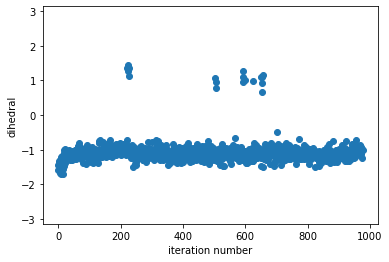

In [10]:
uncorrelated_old = plot_time_series(dihedrals_old, n_iter, os.path.join(outdir, f"{i}_{phase}_{name.lower()}_{length}ns_{old_aa_name.lower()}_timeseries.png"))


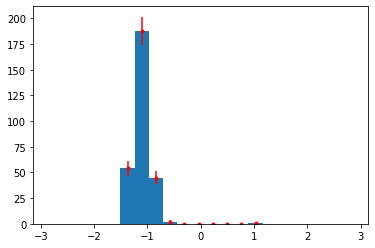

In [11]:
plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old, os.path.join(outdir, f"{i}_{phase}_{name.lower()}_{length}ns_{old_aa_name.lower()}_decorrelated.png"))

In [12]:
for i, angle in enumerate(dihedrals_old):
    if i in uncorrelated_old and angle > -1:
        print(i, angle)

656 [1.1630366]
662 [-0.9251062]
664 [-0.8474216]
669 [-0.87718797]
671 [-0.9804397]
676 [-0.9205101]
681 [-0.79949725]
685 [-0.9776841]
687 [-0.9811941]
689 [-0.95879775]
696 [-0.97049826]
698 [-0.94924164]
700 [-0.8884686]
701 [-0.48902354]
702 [-0.94441736]
706 [-0.83279103]
710 [-0.92659736]
715 [-0.892524]
716 [-0.91968656]
718 [-0.90928525]
726 [-0.97995687]
729 [-0.9879733]
731 [-0.8043231]
732 [-0.98131853]
736 [-0.9276909]
741 [-0.8643714]
742 [-0.9216224]
746 [-0.9475103]
748 [-0.94719297]
754 [-0.97256386]
758 [-0.9091294]
761 [-0.99486905]
767 [-0.93893695]
769 [-0.98911875]
772 [-0.681841]
788 [-0.94792235]
789 [-0.857367]
791 [-0.9649363]
794 [-0.9517005]
796 [-0.9299239]
801 [-0.9689075]
818 [-0.94273806]
820 [-0.99933416]
867 [-0.8372597]
880 [-0.7632188]
900 [-0.99409056]
909 [-0.8549317]
919 [-0.9431136]
922 [-0.7435597]
942 [-0.8478204]
943 [-0.8547347]
947 [-0.9073605]
952 [-0.9700253]
954 [-0.7150641]
960 [-0.91926533]
961 [-0.8839593]
962 [-0.92574376]
969 [-0.868

In [15]:
all_pos_hybrid[uncorrelated_old[:100]].shape

(100, 200489, 3)

In [16]:
i = 16
with open(os.path.join(outdir, f"{i}_{phase}_{name.lower()}_{length}ns_snapshots.npy"), 'wb') as f:
    np.save(f, all_pos_hybrid[uncorrelated_old[:100]])

# Edit cache for lambda = 1 (TYR) of N501Y complex

In [3]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/14/16/"
endstate = 1
phase = "complex"
length = 1
i = 16
old_aa_name = 'ASN'
new_aa_name = 'TYR'
resid = '501'
name = 'tyr'

In [4]:
with open(os.path.join(outdir, f"{i}_{phase}_{endstate}.pickle"), 'rb') as f:
    htf = pickle.load(f)


In [5]:
thr_dihedral = ['N', 'CA', 'CB', 'OG1']
other_dihedral = ['N', 'CA', 'CB', 'CG']
ala_dihedral = ['N', 'CA', 'CB', 'HB1']
asp_dihedral = ['CA', 'CB', 'CG', 'OD2']
ile_dihedral = ['N', 'CA', 'CB', 'CG2']

dihedral_atoms = []
for aa_name in [old_aa_name, new_aa_name]:
    if aa_name in ["PHE", "TYR", "TRP", "GLU", "LYS", "ARG", "GLN", "ASN"]:
        dihedral_atoms.append(other_dihedral)
    elif aa_name == "THR":
        dihedral_atoms.append(thr_dihedral)
    elif aa_name == "ALA":
        dihedral_atoms.append(ala_dihedral)
    elif aa_name == 'ASP':
        dihedral_atoms.append(asp_dihedral)
    elif aa_name == 'ILE':
        dihedral_atoms.append(ile_dihedral)
        

for res in htf._topology_proposal.old_topology.residues():
    if res.id == resid and res.chain.index == 0:
        residue_old = res
for res in htf._topology_proposal.new_topology.residues():
    if res.id == resid and res.chain.index == 0:
        residue_new = res
# indices_old = [atom.index for atom in list(htf._topology_proposal.old_topology.residues())[int(args.resid)].atoms() if atom.name in dihedral_atoms[0]]
# indices_new = [atom.index for atom in list(htf._topology_proposal.new_topology.residues())[int(args.resid)].atoms() if atom.name in dihedral_atoms[1]]
indices_old = [atom.index for atom in residue_old.atoms() if atom.name in dihedral_atoms[0]]
indices_new = [atom.index for atom in residue_new.atoms() if atom.name in dihedral_atoms[1]]
_logger.info(f"old indices: {indices_old}")
_logger.info(f"new indices: {indices_new}")



INFO:root:old indices: [2605, 2607, 2609, 2612]
INFO:root:new indices: [2605, 2607, 2609, 2612]


In [6]:
dihedrals, n_iter, all_pos_hybrid = get_dihedrals(i, name, length, outdir, htf, indices_new, indices_old)


  0%|          | 1/1001 [00:00<02:48,  5.92it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  0%|          | 3/1001 [00:00<02:18,  7.20it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  0%|          | 5/1001 [00:00<02:12,  7.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  1%|          | 7/1001 [00:00<02:07,  7.78it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  1%|          | 9/1001 [00:01<02:04,  7.95it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  1%|          | 11/1001 [00:01<02:04,  7.96it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  1%|▏         | 13/1001 [00:01<02:02,  8.06it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  1%|▏         | 15/1001 [00:01<02:01,  8.14it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  2%|▏         | 17/1001 [00:02<02:00,  8.14it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  2%|▏         | 19/1001 [00:02<01:59,  8.20it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  2%|▏         | 21/1001 [00:02<01:58,  8.24it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  2%|▏         | 23/1001 [00:02<01:58,  8.27it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  2%|▏         | 25/1001 [00:03<01:58,  8.26it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  3%|▎         | 27/1001 [00:03<01:57,  8.27it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  3%|▎         | 29/1001 [00:03<01:58,  8.23it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  3%|▎         | 31/1001 [00:03<01:57,  8.26it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  3%|▎         | 33/1001 [00:04<01:56,  8.31it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  3%|▎         | 35/1001 [00:04<01:56,  8.29it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  4%|▎         | 37/1001 [00:04<01:56,  8.30it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  4%|▍         | 39/1001 [00:04<01:55,  8.30it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  4%|▍         | 41/1001 [00:05<01:55,  8.35it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  4%|▍         | 43/1001 [00:05<01:54,  8.37it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  4%|▍         | 45/1001 [00:05<01:54,  8.33it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  5%|▍         | 47/1001 [00:05<01:55,  8.27it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  5%|▍         | 49/1001 [00:06<01:55,  8.21it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  5%|▌         | 51/1001 [00:06<01:56,  8.18it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  5%|▌         | 53/1001 [00:06<01:55,  8.21it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  5%|▌         | 55/1001 [00:06<01:54,  8.23it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  6%|▌         | 57/1001 [00:07<01:54,  8.25it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  6%|▌         | 59/1001 [00:07<01:54,  8.21it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  6%|▌         | 61/1001 [00:07<01:53,  8.25it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  6%|▋         | 63/1001 [00:07<01:53,  8.29it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  6%|▋         | 65/1001 [00:07<01:53,  8.26it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  7%|▋         | 67/1001 [00:08<01:52,  8.27it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  7%|▋         | 69/1001 [00:08<01:53,  8.25it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  7%|▋         | 71/1001 [00:08<01:52,  8.25it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  7%|▋         | 73/1001 [00:08<01:51,  8.29it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  7%|▋         | 75/1001 [00:09<01:50,  8.35it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  8%|▊         | 77/1001 [00:09<01:51,  8.27it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  8%|▊         | 79/1001 [00:09<01:52,  8.17it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  8%|▊         | 81/1001 [00:09<01:53,  8.10it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  8%|▊         | 83/1001 [00:10<01:54,  8.03it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  8%|▊         | 85/1001 [00:10<01:54,  7.99it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  9%|▊         | 87/1001 [00:10<01:53,  8.05it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  9%|▉         | 89/1001 [00:10<01:53,  8.06it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  9%|▉         | 91/1001 [00:11<01:53,  8.05it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  9%|▉         | 93/1001 [00:11<01:52,  8.07it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


  9%|▉         | 95/1001 [00:11<01:52,  8.04it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 10%|▉         | 97/1001 [00:11<01:51,  8.11it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 10%|▉         | 99/1001 [00:12<01:49,  8.23it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 10%|█         | 101/1001 [00:12<01:48,  8.27it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 10%|█         | 103/1001 [00:12<01:50,  8.13it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 10%|█         | 105/1001 [00:12<01:50,  8.10it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 11%|█         | 107/1001 [00:13<01:50,  8.10it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 11%|█         | 109/1001 [00:13<01:50,  8.07it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 11%|█         | 111/1001 [00:13<01:49,  8.09it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 11%|█▏        | 113/1001 [00:13<01:49,  8.11it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 11%|█▏        | 115/1001 [00:14<01:48,  8.18it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 12%|█▏        | 117/1001 [00:14<01:48,  8.16it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 12%|█▏        | 119/1001 [00:14<01:48,  8.16it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 12%|█▏        | 121/1001 [00:14<01:47,  8.16it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 12%|█▏        | 123/1001 [00:15<01:47,  8.18it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 12%|█▏        | 125/1001 [00:15<01:46,  8.21it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 13%|█▎        | 127/1001 [00:15<01:46,  8.18it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 13%|█▎        | 129/1001 [00:15<01:46,  8.22it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 13%|█▎        | 131/1001 [00:16<01:44,  8.35it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 13%|█▎        | 133/1001 [00:16<01:45,  8.24it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 13%|█▎        | 135/1001 [00:16<01:45,  8.17it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 14%|█▎        | 137/1001 [00:16<01:44,  8.29it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 14%|█▍        | 139/1001 [00:17<01:42,  8.43it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 14%|█▍        | 141/1001 [00:17<01:41,  8.47it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 14%|█▍        | 143/1001 [00:17<01:40,  8.56it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 14%|█▍        | 145/1001 [00:17<01:40,  8.48it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 15%|█▍        | 147/1001 [00:17<01:39,  8.57it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 15%|█▍        | 149/1001 [00:18<01:39,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 15%|█▌        | 151/1001 [00:18<01:39,  8.56it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 15%|█▌        | 153/1001 [00:18<01:39,  8.55it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 15%|█▌        | 155/1001 [00:18<01:38,  8.55it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 16%|█▌        | 157/1001 [00:19<01:38,  8.57it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 16%|█▌        | 159/1001 [00:19<01:38,  8.58it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 16%|█▌        | 161/1001 [00:19<01:38,  8.54it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 16%|█▋        | 163/1001 [00:19<01:38,  8.48it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 16%|█▋        | 165/1001 [00:20<01:38,  8.49it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 17%|█▋        | 167/1001 [00:20<01:37,  8.54it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 17%|█▋        | 169/1001 [00:20<01:37,  8.54it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 17%|█▋        | 171/1001 [00:20<01:38,  8.45it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 17%|█▋        | 173/1001 [00:21<01:38,  8.42it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 17%|█▋        | 175/1001 [00:21<01:38,  8.38it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 18%|█▊        | 177/1001 [00:21<01:39,  8.31it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 18%|█▊        | 179/1001 [00:21<01:39,  8.25it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 18%|█▊        | 181/1001 [00:22<01:40,  8.14it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 18%|█▊        | 183/1001 [00:22<01:41,  8.10it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 18%|█▊        | 185/1001 [00:22<01:41,  8.08it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 19%|█▊        | 187/1001 [00:22<01:41,  8.02it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 19%|█▉        | 189/1001 [00:23<01:40,  8.07it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 19%|█▉        | 191/1001 [00:23<01:39,  8.10it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 19%|█▉        | 193/1001 [00:23<01:39,  8.11it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 19%|█▉        | 195/1001 [00:23<01:39,  8.09it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 20%|█▉        | 197/1001 [00:24<01:39,  8.09it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 20%|█▉        | 199/1001 [00:24<01:38,  8.11it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 20%|██        | 201/1001 [00:24<01:32,  8.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 20%|██        | 203/1001 [00:24<01:34,  8.41it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 20%|██        | 205/1001 [00:24<01:35,  8.31it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 21%|██        | 207/1001 [00:25<01:36,  8.25it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 21%|██        | 209/1001 [00:25<01:37,  8.15it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 21%|██        | 211/1001 [00:25<01:38,  8.05it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 21%|██▏       | 213/1001 [00:25<01:37,  8.07it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 21%|██▏       | 215/1001 [00:26<01:37,  8.08it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 22%|██▏       | 217/1001 [00:26<01:36,  8.14it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 22%|██▏       | 219/1001 [00:26<01:36,  8.14it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 22%|██▏       | 221/1001 [00:26<01:35,  8.19it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 22%|██▏       | 223/1001 [00:27<01:35,  8.18it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 22%|██▏       | 225/1001 [00:27<01:34,  8.18it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 23%|██▎       | 227/1001 [00:27<01:34,  8.19it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 23%|██▎       | 229/1001 [00:27<01:33,  8.27it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 23%|██▎       | 231/1001 [00:28<01:32,  8.34it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 23%|██▎       | 233/1001 [00:28<01:31,  8.42it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 23%|██▎       | 235/1001 [00:28<01:30,  8.44it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 24%|██▎       | 237/1001 [00:28<01:30,  8.43it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 24%|██▍       | 239/1001 [00:29<01:31,  8.35it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 24%|██▍       | 241/1001 [00:29<01:31,  8.28it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 24%|██▍       | 243/1001 [00:29<01:31,  8.25it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 24%|██▍       | 245/1001 [00:29<01:33,  8.13it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 25%|██▍       | 247/1001 [00:30<01:33,  8.08it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 25%|██▍       | 249/1001 [00:30<01:32,  8.16it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 25%|██▌       | 251/1001 [00:30<01:30,  8.27it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 25%|██▌       | 253/1001 [00:30<01:30,  8.28it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 25%|██▌       | 255/1001 [00:31<01:30,  8.28it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 26%|██▌       | 257/1001 [00:31<01:30,  8.25it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 26%|██▌       | 259/1001 [00:31<01:28,  8.36it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 26%|██▌       | 261/1001 [00:31<01:27,  8.43it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 26%|██▋       | 263/1001 [00:32<01:27,  8.39it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 26%|██▋       | 265/1001 [00:32<01:27,  8.45it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 27%|██▋       | 267/1001 [00:32<01:26,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 27%|██▋       | 269/1001 [00:32<01:26,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 27%|██▋       | 271/1001 [00:32<01:26,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 27%|██▋       | 273/1001 [00:33<01:25,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 27%|██▋       | 275/1001 [00:33<01:26,  8.39it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 28%|██▊       | 277/1001 [00:33<01:22,  8.76it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 28%|██▊       | 279/1001 [00:33<01:23,  8.68it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 28%|██▊       | 281/1001 [00:34<01:23,  8.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 28%|██▊       | 283/1001 [00:34<01:23,  8.64it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 28%|██▊       | 285/1001 [00:34<01:23,  8.63it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 29%|██▊       | 287/1001 [00:34<01:22,  8.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 29%|██▉       | 289/1001 [00:35<01:21,  8.69it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 29%|██▉       | 291/1001 [00:35<01:20,  8.80it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 29%|██▉       | 293/1001 [00:35<01:20,  8.80it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 29%|██▉       | 295/1001 [00:35<01:21,  8.69it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 30%|██▉       | 297/1001 [00:35<01:20,  8.78it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 30%|██▉       | 299/1001 [00:36<01:19,  8.79it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 30%|███       | 301/1001 [00:36<01:19,  8.83it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 30%|███       | 303/1001 [00:36<01:19,  8.80it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 30%|███       | 305/1001 [00:36<01:18,  8.85it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 31%|███       | 307/1001 [00:37<01:17,  8.90it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 31%|███       | 309/1001 [00:37<01:17,  8.90it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 31%|███       | 311/1001 [00:37<01:17,  8.87it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 31%|███▏      | 313/1001 [00:37<01:17,  8.88it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 31%|███▏      | 315/1001 [00:37<01:17,  8.85it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 32%|███▏      | 317/1001 [00:38<01:17,  8.83it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 32%|███▏      | 319/1001 [00:38<01:33,  7.30it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 32%|███▏      | 320/1001 [00:38<01:49,  6.20it/s]

shape  (200489, 3)
shape  (200489, 3)


 32%|███▏      | 321/1001 [00:38<02:02,  5.53it/s]

shape  (200489, 3)
shape  (200489, 3)


 32%|███▏      | 322/1001 [00:39<02:14,  5.06it/s]

shape  (200489, 3)
shape  (200489, 3)


 32%|███▏      | 323/1001 [00:39<02:18,  4.90it/s]

shape  (200489, 3)
shape  (200489, 3)


 32%|███▏      | 324/1001 [00:39<02:24,  4.69it/s]

shape  (200489, 3)
shape  (200489, 3)


 33%|███▎      | 326/1001 [00:40<02:25,  4.63it/s]

shape  (200489, 3)
shape  (200489, 3)


 33%|███▎      | 327/1001 [00:40<02:04,  5.41it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 33%|███▎      | 329/1001 [00:40<01:39,  6.76it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 33%|███▎      | 331/1001 [00:40<01:26,  7.75it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 33%|███▎      | 333/1001 [00:40<01:19,  8.38it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 33%|███▎      | 335/1001 [00:41<01:16,  8.70it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 34%|███▎      | 337/1001 [00:41<01:15,  8.85it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 34%|███▍      | 339/1001 [00:41<01:15,  8.82it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 34%|███▍      | 341/1001 [00:41<01:14,  8.80it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 34%|███▍      | 343/1001 [00:41<01:15,  8.76it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 34%|███▍      | 345/1001 [00:42<01:15,  8.70it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 35%|███▍      | 347/1001 [00:42<01:15,  8.68it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 35%|███▍      | 349/1001 [00:42<01:15,  8.68it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 35%|███▌      | 351/1001 [00:42<01:14,  8.72it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 35%|███▌      | 353/1001 [00:43<01:14,  8.71it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 35%|███▌      | 355/1001 [00:43<01:14,  8.70it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 36%|███▌      | 357/1001 [00:43<01:13,  8.79it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 36%|███▌      | 359/1001 [00:43<01:13,  8.77it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 36%|███▌      | 361/1001 [00:44<01:13,  8.71it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 36%|███▋      | 363/1001 [00:44<01:13,  8.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 36%|███▋      | 365/1001 [00:44<01:14,  8.51it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 37%|███▋      | 367/1001 [00:44<01:14,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 37%|███▋      | 369/1001 [00:45<01:14,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 37%|███▋      | 371/1001 [00:45<01:13,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 37%|███▋      | 373/1001 [00:45<01:14,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 37%|███▋      | 375/1001 [00:45<01:14,  8.38it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 38%|███▊      | 377/1001 [00:45<01:14,  8.32it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 38%|███▊      | 379/1001 [00:46<01:14,  8.37it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 38%|███▊      | 381/1001 [00:46<01:13,  8.40it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 38%|███▊      | 383/1001 [00:46<01:12,  8.47it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 38%|███▊      | 385/1001 [00:46<01:11,  8.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 39%|███▊      | 387/1001 [00:47<01:11,  8.64it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 39%|███▉      | 389/1001 [00:47<01:11,  8.58it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 39%|███▉      | 391/1001 [00:47<01:10,  8.64it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 39%|███▉      | 393/1001 [00:47<01:10,  8.57it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 39%|███▉      | 395/1001 [00:48<01:10,  8.55it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 40%|███▉      | 397/1001 [00:48<01:10,  8.60it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 40%|███▉      | 399/1001 [00:48<01:10,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 40%|████      | 401/1001 [00:48<01:09,  8.64it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 40%|████      | 403/1001 [00:49<01:09,  8.58it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 40%|████      | 405/1001 [00:49<01:09,  8.57it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 41%|████      | 407/1001 [00:49<01:09,  8.49it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 41%|████      | 409/1001 [00:49<01:10,  8.41it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 41%|████      | 411/1001 [00:49<01:09,  8.43it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 41%|████▏     | 413/1001 [00:50<01:09,  8.43it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 41%|████▏     | 415/1001 [00:50<01:09,  8.48it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 42%|████▏     | 417/1001 [00:50<01:09,  8.45it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 42%|████▏     | 419/1001 [00:50<01:08,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 42%|████▏     | 421/1001 [00:51<01:08,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 42%|████▏     | 423/1001 [00:51<01:08,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 42%|████▏     | 425/1001 [00:51<01:07,  8.47it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 43%|████▎     | 427/1001 [00:51<01:07,  8.52it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 43%|████▎     | 429/1001 [00:52<01:07,  8.49it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 43%|████▎     | 431/1001 [00:52<01:07,  8.48it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 43%|████▎     | 433/1001 [00:52<01:06,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 43%|████▎     | 435/1001 [00:52<01:06,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 44%|████▎     | 437/1001 [00:53<01:05,  8.59it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 44%|████▍     | 439/1001 [00:53<01:05,  8.55it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 44%|████▍     | 441/1001 [00:53<01:05,  8.51it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 44%|████▍     | 443/1001 [00:53<01:06,  8.44it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 44%|████▍     | 445/1001 [00:53<01:06,  8.42it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 45%|████▍     | 447/1001 [00:54<01:05,  8.41it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 45%|████▍     | 449/1001 [00:54<01:05,  8.41it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 45%|████▌     | 451/1001 [00:54<01:05,  8.41it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 45%|████▌     | 453/1001 [00:54<01:05,  8.40it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 45%|████▌     | 455/1001 [00:55<01:04,  8.44it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 46%|████▌     | 457/1001 [00:55<01:04,  8.44it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 46%|████▌     | 459/1001 [00:55<01:03,  8.47it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 46%|████▌     | 461/1001 [00:55<01:03,  8.48it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 46%|████▋     | 463/1001 [00:56<01:03,  8.51it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 46%|████▋     | 465/1001 [00:56<01:03,  8.49it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 47%|████▋     | 467/1001 [00:56<01:02,  8.55it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 47%|████▋     | 469/1001 [00:56<01:02,  8.55it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 47%|████▋     | 471/1001 [00:57<01:01,  8.56it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 47%|████▋     | 473/1001 [00:57<01:01,  8.61it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 47%|████▋     | 475/1001 [00:57<01:01,  8.57it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 48%|████▊     | 477/1001 [00:57<01:01,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 48%|████▊     | 479/1001 [00:57<01:01,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 48%|████▊     | 481/1001 [00:58<01:01,  8.40it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 48%|████▊     | 483/1001 [00:58<01:01,  8.45it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 48%|████▊     | 485/1001 [00:58<01:00,  8.52it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 49%|████▊     | 487/1001 [00:58<00:59,  8.62it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 49%|████▉     | 489/1001 [00:59<00:58,  8.74it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 49%|████▉     | 491/1001 [00:59<00:58,  8.68it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 49%|████▉     | 493/1001 [00:59<00:58,  8.68it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 49%|████▉     | 495/1001 [00:59<00:58,  8.72it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 50%|████▉     | 497/1001 [01:00<00:58,  8.68it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 50%|████▉     | 499/1001 [01:00<00:58,  8.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 50%|█████     | 501/1001 [01:00<00:57,  8.62it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 50%|█████     | 503/1001 [01:00<00:57,  8.62it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 50%|█████     | 505/1001 [01:00<00:57,  8.61it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 51%|█████     | 507/1001 [01:01<00:57,  8.60it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 51%|█████     | 509/1001 [01:01<00:57,  8.59it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 51%|█████     | 511/1001 [01:01<00:56,  8.62it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 51%|█████     | 513/1001 [01:01<00:57,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 51%|█████▏    | 515/1001 [01:02<00:57,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 52%|█████▏    | 517/1001 [01:02<00:56,  8.54it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 52%|█████▏    | 519/1001 [01:02<00:56,  8.58it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 52%|█████▏    | 521/1001 [01:02<00:55,  8.63it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 52%|█████▏    | 523/1001 [01:03<00:55,  8.60it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 52%|█████▏    | 525/1001 [01:03<00:55,  8.57it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 53%|█████▎    | 527/1001 [01:03<00:54,  8.64it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 53%|█████▎    | 529/1001 [01:03<00:54,  8.63it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 53%|█████▎    | 531/1001 [01:04<00:54,  8.59it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 53%|█████▎    | 533/1001 [01:04<00:54,  8.59it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 53%|█████▎    | 535/1001 [01:04<00:54,  8.61it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 54%|█████▎    | 537/1001 [01:04<00:54,  8.59it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 54%|█████▍    | 539/1001 [01:04<00:54,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 54%|█████▍    | 541/1001 [01:05<00:53,  8.55it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 54%|█████▍    | 543/1001 [01:05<00:53,  8.55it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 54%|█████▍    | 545/1001 [01:05<00:53,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 55%|█████▍    | 547/1001 [01:05<00:53,  8.56it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 55%|█████▍    | 549/1001 [01:06<00:52,  8.69it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 55%|█████▌    | 551/1001 [01:06<00:51,  8.80it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 55%|█████▌    | 553/1001 [01:06<00:51,  8.76it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 55%|█████▌    | 555/1001 [01:06<00:50,  8.81it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 56%|█████▌    | 557/1001 [01:07<00:50,  8.84it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 56%|█████▌    | 559/1001 [01:07<00:50,  8.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 56%|█████▌    | 561/1001 [01:07<00:50,  8.69it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 56%|█████▌    | 563/1001 [01:07<00:51,  8.57it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 56%|█████▋    | 565/1001 [01:07<00:50,  8.56it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 57%|█████▋    | 567/1001 [01:08<00:51,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 57%|█████▋    | 569/1001 [01:08<00:50,  8.49it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 57%|█████▋    | 571/1001 [01:08<00:51,  8.42it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 57%|█████▋    | 573/1001 [01:08<00:50,  8.40it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 57%|█████▋    | 575/1001 [01:09<00:50,  8.51it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 58%|█████▊    | 577/1001 [01:09<00:49,  8.59it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 58%|█████▊    | 579/1001 [01:09<00:48,  8.63it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 58%|█████▊    | 581/1001 [01:09<00:48,  8.64it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 58%|█████▊    | 583/1001 [01:10<00:48,  8.62it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 58%|█████▊    | 585/1001 [01:10<00:48,  8.56it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 59%|█████▊    | 587/1001 [01:10<00:48,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 59%|█████▉    | 589/1001 [01:10<00:48,  8.52it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 59%|█████▉    | 591/1001 [01:11<00:47,  8.56it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 59%|█████▉    | 593/1001 [01:11<00:47,  8.58it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 59%|█████▉    | 595/1001 [01:11<00:47,  8.55it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 60%|█████▉    | 597/1001 [01:11<00:46,  8.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 60%|█████▉    | 599/1001 [01:11<00:45,  8.80it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 60%|██████    | 601/1001 [01:12<00:45,  8.73it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 60%|██████    | 603/1001 [01:12<00:45,  8.79it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 60%|██████    | 605/1001 [01:12<00:44,  8.83it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 61%|██████    | 607/1001 [01:12<00:44,  8.77it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 61%|██████    | 609/1001 [01:13<00:45,  8.70it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 61%|██████    | 611/1001 [01:13<00:45,  8.66it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 61%|██████    | 613/1001 [01:13<00:44,  8.64it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 61%|██████▏   | 615/1001 [01:13<00:44,  8.69it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 62%|██████▏   | 617/1001 [01:14<00:44,  8.63it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 62%|██████▏   | 619/1001 [01:14<00:45,  8.48it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 62%|██████▏   | 621/1001 [01:14<00:44,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 62%|██████▏   | 623/1001 [01:14<00:44,  8.43it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 62%|██████▏   | 625/1001 [01:14<00:44,  8.47it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 63%|██████▎   | 627/1001 [01:15<00:43,  8.51it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 63%|██████▎   | 629/1001 [01:15<00:43,  8.55it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 63%|██████▎   | 631/1001 [01:15<00:43,  8.47it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 63%|██████▎   | 633/1001 [01:15<00:43,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 63%|██████▎   | 635/1001 [01:16<00:42,  8.64it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 64%|██████▎   | 637/1001 [01:16<00:41,  8.82it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 64%|██████▍   | 639/1001 [01:16<00:40,  8.92it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 64%|██████▍   | 641/1001 [01:16<00:40,  8.86it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 64%|██████▍   | 643/1001 [01:17<00:41,  8.71it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 64%|██████▍   | 645/1001 [01:17<00:40,  8.70it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 65%|██████▍   | 647/1001 [01:17<00:40,  8.70it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 65%|██████▍   | 649/1001 [01:17<00:41,  8.58it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 65%|██████▌   | 651/1001 [01:17<00:41,  8.45it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 65%|██████▌   | 653/1001 [01:18<00:41,  8.42it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 65%|██████▌   | 655/1001 [01:18<00:41,  8.42it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 66%|██████▌   | 657/1001 [01:18<00:40,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 66%|██████▌   | 659/1001 [01:18<00:40,  8.51it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 66%|██████▌   | 661/1001 [01:19<00:39,  8.54it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 66%|██████▌   | 663/1001 [01:19<00:39,  8.52it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 66%|██████▋   | 665/1001 [01:19<00:39,  8.58it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 67%|██████▋   | 667/1001 [01:19<00:38,  8.62it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 67%|██████▋   | 669/1001 [01:20<00:38,  8.56it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 67%|██████▋   | 671/1001 [01:20<00:38,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 67%|██████▋   | 673/1001 [01:20<00:38,  8.48it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 67%|██████▋   | 675/1001 [01:20<00:38,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 68%|██████▊   | 677/1001 [01:21<00:37,  8.56it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 68%|██████▊   | 679/1001 [01:21<00:37,  8.57it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 68%|██████▊   | 681/1001 [01:21<00:37,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 68%|██████▊   | 683/1001 [01:21<00:37,  8.54it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 68%|██████▊   | 685/1001 [01:21<00:36,  8.61it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 69%|██████▊   | 687/1001 [01:22<00:36,  8.62it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 69%|██████▉   | 689/1001 [01:22<00:35,  8.72it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 69%|██████▉   | 691/1001 [01:22<00:35,  8.74it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 69%|██████▉   | 693/1001 [01:22<00:35,  8.74it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 69%|██████▉   | 695/1001 [01:23<00:34,  8.78it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 70%|██████▉   | 697/1001 [01:23<00:34,  8.70it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 70%|██████▉   | 699/1001 [01:23<00:35,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 70%|███████   | 701/1001 [01:23<00:35,  8.42it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 70%|███████   | 703/1001 [01:24<00:35,  8.38it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 70%|███████   | 705/1001 [01:24<00:35,  8.39it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 71%|███████   | 707/1001 [01:24<00:34,  8.42it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 71%|███████   | 709/1001 [01:24<00:34,  8.40it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 71%|███████   | 711/1001 [01:25<00:34,  8.37it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 71%|███████   | 713/1001 [01:25<00:34,  8.42it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 71%|███████▏  | 715/1001 [01:25<00:33,  8.45it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 72%|███████▏  | 717/1001 [01:25<00:33,  8.38it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 72%|███████▏  | 719/1001 [01:25<00:33,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 72%|███████▏  | 721/1001 [01:26<00:32,  8.63it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 72%|███████▏  | 723/1001 [01:26<00:31,  8.72it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 72%|███████▏  | 725/1001 [01:26<00:31,  8.77it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 73%|███████▎  | 727/1001 [01:26<00:31,  8.73it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 73%|███████▎  | 729/1001 [01:27<00:31,  8.72it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 73%|███████▎  | 731/1001 [01:27<00:30,  8.80it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 73%|███████▎  | 733/1001 [01:27<00:30,  8.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 73%|███████▎  | 735/1001 [01:27<00:30,  8.62it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 74%|███████▎  | 737/1001 [01:28<00:30,  8.62it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 74%|███████▍  | 739/1001 [01:28<00:30,  8.63it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 74%|███████▍  | 741/1001 [01:28<00:29,  8.69it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 74%|███████▍  | 743/1001 [01:28<00:29,  8.76it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 74%|███████▍  | 745/1001 [01:28<00:29,  8.79it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 75%|███████▍  | 747/1001 [01:29<00:29,  8.69it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 75%|███████▍  | 749/1001 [01:29<00:29,  8.69it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 75%|███████▌  | 751/1001 [01:29<00:28,  8.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 75%|███████▌  | 753/1001 [01:29<00:28,  8.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 75%|███████▌  | 755/1001 [01:30<00:28,  8.58it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 76%|███████▌  | 757/1001 [01:30<00:28,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 76%|███████▌  | 759/1001 [01:30<00:28,  8.55it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 76%|███████▌  | 761/1001 [01:30<00:27,  8.61it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 76%|███████▌  | 763/1001 [01:31<00:27,  8.56it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 76%|███████▋  | 765/1001 [01:31<00:27,  8.48it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 77%|███████▋  | 767/1001 [01:31<00:27,  8.41it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 77%|███████▋  | 769/1001 [01:31<00:27,  8.41it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 77%|███████▋  | 771/1001 [01:31<00:27,  8.39it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 77%|███████▋  | 773/1001 [01:32<00:26,  8.52it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 77%|███████▋  | 775/1001 [01:32<00:26,  8.47it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 78%|███████▊  | 777/1001 [01:32<00:26,  8.44it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 78%|███████▊  | 779/1001 [01:32<00:26,  8.49it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 78%|███████▊  | 781/1001 [01:33<00:25,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 78%|███████▊  | 783/1001 [01:33<00:25,  8.47it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 78%|███████▊  | 785/1001 [01:33<00:25,  8.37it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 79%|███████▊  | 787/1001 [01:33<00:25,  8.41it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 79%|███████▉  | 789/1001 [01:34<00:25,  8.47it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 79%|███████▉  | 791/1001 [01:34<00:24,  8.55it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 79%|███████▉  | 793/1001 [01:34<00:24,  8.55it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 79%|███████▉  | 795/1001 [01:34<00:24,  8.58it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 80%|███████▉  | 797/1001 [01:35<00:23,  8.57it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 80%|███████▉  | 799/1001 [01:35<00:23,  8.60it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 80%|████████  | 801/1001 [01:35<00:23,  8.56it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 80%|████████  | 803/1001 [01:35<00:23,  8.45it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 80%|████████  | 805/1001 [01:36<00:23,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 81%|████████  | 807/1001 [01:36<00:22,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 81%|████████  | 809/1001 [01:36<00:22,  8.45it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 81%|████████  | 811/1001 [01:36<00:22,  8.40it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 81%|████████  | 813/1001 [01:36<00:22,  8.48it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 81%|████████▏ | 815/1001 [01:37<00:21,  8.47it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 82%|████████▏ | 817/1001 [01:37<00:21,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 82%|████████▏ | 819/1001 [01:37<00:21,  8.48it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 82%|████████▏ | 821/1001 [01:37<00:21,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 82%|████████▏ | 823/1001 [01:38<00:20,  8.60it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 82%|████████▏ | 825/1001 [01:38<00:20,  8.71it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 83%|████████▎ | 827/1001 [01:38<00:20,  8.65it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 83%|████████▎ | 829/1001 [01:38<00:20,  8.57it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 83%|████████▎ | 831/1001 [01:39<00:19,  8.64it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 83%|████████▎ | 833/1001 [01:39<00:19,  8.62it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 83%|████████▎ | 835/1001 [01:39<00:19,  8.58it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 84%|████████▎ | 837/1001 [01:39<00:18,  8.71it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 84%|████████▍ | 839/1001 [01:39<00:18,  8.81it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 84%|████████▍ | 841/1001 [01:40<00:18,  8.74it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 84%|████████▍ | 843/1001 [01:40<00:18,  8.72it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 84%|████████▍ | 845/1001 [01:40<00:17,  9.12it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 85%|████████▍ | 847/1001 [01:40<00:17,  8.95it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 85%|████████▍ | 849/1001 [01:41<00:17,  8.80it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 85%|████████▌ | 851/1001 [01:41<00:17,  8.66it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 85%|████████▌ | 853/1001 [01:41<00:17,  8.52it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 85%|████████▌ | 855/1001 [01:41<00:17,  8.51it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 86%|████████▌ | 857/1001 [01:42<00:17,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 86%|████████▌ | 859/1001 [01:42<00:16,  8.45it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 86%|████████▌ | 861/1001 [01:42<00:16,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 86%|████████▌ | 863/1001 [01:42<00:16,  8.45it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 86%|████████▋ | 865/1001 [01:42<00:16,  8.40it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 87%|████████▋ | 867/1001 [01:43<00:16,  8.36it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 87%|████████▋ | 869/1001 [01:43<00:15,  8.45it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 87%|████████▋ | 871/1001 [01:43<00:15,  8.51it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 87%|████████▋ | 873/1001 [01:43<00:15,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 87%|████████▋ | 875/1001 [01:44<00:14,  8.45it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 88%|████████▊ | 877/1001 [01:44<00:14,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 88%|████████▊ | 879/1001 [01:44<00:13,  8.73it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 88%|████████▊ | 881/1001 [01:44<00:13,  8.83it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 88%|████████▊ | 883/1001 [01:45<00:13,  9.03it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 88%|████████▊ | 885/1001 [01:45<00:13,  8.88it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 89%|████████▊ | 887/1001 [01:45<00:13,  8.73it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 89%|████████▉ | 889/1001 [01:45<00:12,  8.62it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 89%|████████▉ | 891/1001 [01:46<00:13,  8.45it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 89%|████████▉ | 893/1001 [01:46<00:12,  8.41it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 89%|████████▉ | 895/1001 [01:46<00:12,  8.42it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 90%|████████▉ | 897/1001 [01:46<00:12,  8.45it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 90%|████████▉ | 899/1001 [01:46<00:11,  8.56it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 90%|█████████ | 901/1001 [01:47<00:11,  8.56it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 90%|█████████ | 903/1001 [01:47<00:11,  8.54it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 90%|█████████ | 905/1001 [01:47<00:11,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 91%|█████████ | 907/1001 [01:47<00:11,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 91%|█████████ | 909/1001 [01:48<00:10,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 91%|█████████ | 911/1001 [01:48<00:10,  8.71it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 91%|█████████ | 913/1001 [01:48<00:10,  8.55it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 91%|█████████▏| 915/1001 [01:48<00:10,  8.49it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 92%|█████████▏| 917/1001 [01:49<00:09,  8.51it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 92%|█████████▏| 919/1001 [01:49<00:09,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 92%|█████████▏| 921/1001 [01:49<00:09,  8.42it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 92%|█████████▏| 923/1001 [01:49<00:09,  8.41it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 92%|█████████▏| 925/1001 [01:50<00:09,  8.39it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 93%|█████████▎| 927/1001 [01:50<00:08,  8.43it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 93%|█████████▎| 929/1001 [01:50<00:08,  8.48it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 93%|█████████▎| 931/1001 [01:50<00:08,  8.52it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 93%|█████████▎| 933/1001 [01:50<00:08,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 93%|█████████▎| 935/1001 [01:51<00:07,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 94%|█████████▎| 937/1001 [01:51<00:07,  8.56it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 94%|█████████▍| 939/1001 [01:51<00:07,  8.59it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 94%|█████████▍| 941/1001 [01:51<00:07,  8.55it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 94%|█████████▍| 943/1001 [01:52<00:06,  8.51it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 94%|█████████▍| 945/1001 [01:52<00:06,  8.54it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 95%|█████████▍| 947/1001 [01:52<00:06,  8.55it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 95%|█████████▍| 949/1001 [01:52<00:06,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 95%|█████████▌| 951/1001 [01:53<00:05,  8.44it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 95%|█████████▌| 953/1001 [01:53<00:05,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 95%|█████████▌| 955/1001 [01:53<00:05,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 96%|█████████▌| 957/1001 [01:53<00:05,  8.44it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 96%|█████████▌| 959/1001 [01:54<00:04,  8.42it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 96%|█████████▌| 961/1001 [01:54<00:04,  8.46it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 96%|█████████▌| 963/1001 [01:54<00:04,  8.52it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 96%|█████████▋| 965/1001 [01:54<00:04,  8.50it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 97%|█████████▋| 967/1001 [01:54<00:03,  8.57it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 97%|█████████▋| 969/1001 [01:55<00:03,  8.66it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 97%|█████████▋| 971/1001 [01:55<00:03,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 97%|█████████▋| 973/1001 [01:55<00:03,  8.42it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 97%|█████████▋| 975/1001 [01:55<00:03,  8.38it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 98%|█████████▊| 977/1001 [01:56<00:02,  8.35it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 98%|█████████▊| 979/1001 [01:56<00:02,  8.38it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 98%|█████████▊| 981/1001 [01:56<00:02,  8.83it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 98%|█████████▊| 983/1001 [01:56<00:02,  8.67it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 98%|█████████▊| 985/1001 [01:57<00:01,  8.62it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 99%|█████████▊| 987/1001 [01:57<00:01,  8.53it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 99%|█████████▉| 989/1001 [01:57<00:01,  8.44it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 99%|█████████▉| 991/1001 [01:57<00:01,  8.43it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 99%|█████████▉| 993/1001 [01:58<00:00,  8.40it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


 99%|█████████▉| 995/1001 [01:58<00:00,  8.37it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


100%|█████████▉| 997/1001 [01:58<00:00,  8.45it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


100%|█████████▉| 999/1001 [01:58<00:00,  8.48it/s]

shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)
shape  (200489, 3)


100%|██████████| 1001/1001 [01:58<00:00,  8.41it/s]


shape  (200489, 3)
shape  (200489, 3)


In [11]:
dihedrals_new = dihedrals[0]

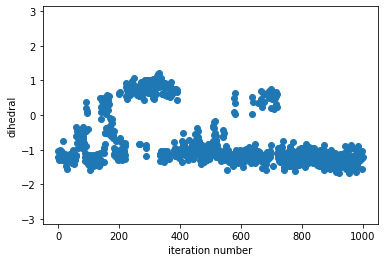

In [12]:
uncorrelated_new = plot_time_series(dihedrals_new, n_iter, os.path.join(outdir, f"{i}_{phase}_{name.lower()}_{length}ns_{old_aa_name.lower()}_timeseries.png"))


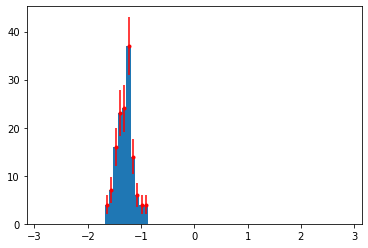

In [13]:
plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new, os.path.join(outdir, f"{i}_{phase}_{name.lower()}_{length}ns_{old_aa_name.lower()}_decorrelated.png"))

In [18]:
for i, angle in enumerate(dihedrals_new):
    if  angle > 0.8:
        print(i, angle)

222 [0.8179052]
223 [0.93392485]
229 [0.8234458]
238 [0.90518904]
239 [0.8207385]
243 [0.99443674]
245 [0.8159227]
246 [0.8996909]
247 [0.8779464]
249 [1.0579393]
259 [0.8221739]
261 [0.8021666]
265 [0.8408781]
266 [0.82724404]
272 [0.95901126]
274 [0.8782175]
280 [0.805031]
281 [0.9859028]
284 [1.0141008]
285 [1.0005915]
291 [0.87642187]
293 [1.01102]
294 [0.86466646]
297 [0.8140314]
299 [1.0023717]
300 [0.9760202]
302 [0.89687735]
304 [1.0252327]
305 [0.84669787]
306 [0.9112288]
307 [0.81423146]
311 [0.8325752]
313 [1.0548314]
314 [0.92534715]
317 [0.80840605]
318 [0.80364496]
321 [0.8084597]
323 [0.8073689]
324 [1.1301718]
325 [0.98834306]
326 [1.0361518]
327 [1.0244483]
328 [1.1947467]
329 [0.8123977]
330 [0.81764054]
331 [1.2129562]
332 [0.88118213]
338 [1.0578512]
339 [0.90279424]
340 [0.96719855]
341 [0.8354419]
352 [0.9266396]
353 [0.8671265]
354 [0.90760607]
355 [0.9105937]
365 [0.80588937]
367 [0.8292804]
369 [0.8568197]
371 [0.94432807]


choose 249 for snapshots with angle = 1

In [16]:
uncorrelated_new

[848,
 849,
 850,
 851,
 852,
 854,
 855,
 856,
 857,
 858,
 859,
 860,
 861,
 862,
 863,
 865,
 866,
 867,
 868,
 869,
 870,
 871,
 872,
 873,
 874,
 876,
 877,
 878,
 879,
 880,
 881,
 882,
 883,
 884,
 886,
 887,
 888,
 889,
 890,
 891,
 892,
 893,
 894,
 895,
 897,
 898,
 899,
 900,
 901,
 902,
 903,
 904,
 905,
 906,
 908,
 909,
 910,
 911,
 912,
 913,
 914,
 915,
 916,
 918,
 919,
 920,
 921,
 922,
 923,
 924,
 925,
 926,
 927,
 929,
 930,
 931,
 932,
 933,
 934,
 935,
 936,
 937,
 938,
 940,
 941,
 942,
 943,
 944,
 945,
 946,
 947,
 948,
 950,
 951,
 952,
 953,
 954,
 955,
 956,
 957,
 958,
 959,
 961,
 962,
 963,
 964,
 965,
 966,
 967,
 968,
 969,
 970,
 972,
 973,
 974,
 975,
 976,
 977,
 978,
 979,
 980,
 982,
 983,
 984,
 985,
 986,
 987,
 988,
 989,
 990,
 991,
 993,
 994,
 995,
 996,
 997,
 998,
 999,
 1000]

In [20]:
all_pos_hybrid[[249] + uncorrelated_new[:99]].shape

(100, 200489, 3)

In [21]:
i = 16
with open(os.path.join(outdir, f"{i}_{phase}_{name.lower()}_{length}ns_snapshots.npy"), 'wb') as f:
    np.save(f, all_pos_hybrid[[249] + uncorrelated_new[:99]])